# E-commerce Customer Churn Prediction and Segmentation


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# Read the Excel file
df = pd.read_excel('E Commerce Dataset.xlsx', sheet_name='E Comm')
df.head()

CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0  Laptop & Accessory                  2        Single                9   
1              Mobile                  3        Single                7   
2              Mobile                  3        Single                6   
3  Laptop & Accessory                  5        Single                8   
4              Mobile                  5        Single                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                         11.0         1.0         1.0   
1         1                         15.0         0.0         1.0   
2         1                         14.0         0.0         1.0   
3         0                         23.0         0.0         1.0   
4         0                         11.0         1.0         1.0   

   DaySinceLastOrder  CashbackAmount  
0                5.0          159.93  
1                0.0          120.90  
2                3.0          120.28  
3                3.0          134.07  
4                3.0          129.60

## Exploratory Data Analysis (EDA)

In [ ]:
# Basic information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (5630, 20)

Columns: ['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier', 'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

First 5 rows:
   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female      

In [ ]:
# Check data types and missing values
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())


Data Types:
CustomerID                       int64
Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                 float64
dtype: object

Missing Values:
CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
W

In [ ]:
# Basic statistics for numerical variables
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical Variables Summary:")
print(df[numerical_features].describe())

Numerical Variables Summary:
         CustomerID        Churn       Tenure     CityTier  WarehouseToHome  \
count   5630.000000  5630.000000  5366.000000  5630.000000      5379.000000   
mean   52815.500000     0.168384    10.189899     1.654707        15.639896   
std     1625.385339     0.374240     8.557241     0.915389         8.531475   
min    50001.000000     0.000000     0.000000     1.000000         5.000000   
25%    51408.250000     0.000000     2.000000     1.000000         9.000000   
50%    52815.500000     0.000000     9.000000     1.000000        14.000000   
75%    54222.750000     0.000000    16.000000     3.000000        20.000000   
max    55630.000000     1.000000    61.000000     3.000000       127.000000   

       HourSpendOnApp  NumberOfDeviceRegistered  SatisfactionScore  \
count     5375.000000               5630.000000        5630.000000   
mean         2.931535                  3.688988           3.066785   
std          0.721926                  1.023999  

In [ ]:
# Business Metrics
print("Key Business Metrics:")
print(f"Overall Churn Rate: {df['Churn'].mean()*100:.2f}%")
print(f"Average Tenure: {df['Tenure'].mean():.2f} months")
print(f"Average Satisfaction Score: {df['SatisfactionScore'].mean():.2f}")

Key Business Metrics:
Overall Churn Rate: 16.84%
Average Tenure: 10.19 months
Average Satisfaction Score: 3.07


In [ ]:
# Churn Rate by City Tier
print("Churn Rate by City Tier:")
print(df.groupby('CityTier')['Churn'].mean().sort_values(ascending=False).mul(100).round(2))

Churn Rate by City Tier:
CityTier
3    21.37
2    19.83
1    14.51
Name: Churn, dtype: float64


In [ ]:
# Churn Rate by Payment Mode
print("Churn Rate by Payment Mode:")
print(df.groupby('PreferredPaymentMode')['Churn'].mean().sort_values(ascending=False).mul(100).round(2))

Churn Rate by Payment Mode:
PreferredPaymentMode
COD                 28.77
E wallet            22.80
CC                  21.61
UPI                 17.39
Cash on Delivery    15.44
Debit Card          15.38
Credit Card         12.86
Name: Churn, dtype: float64


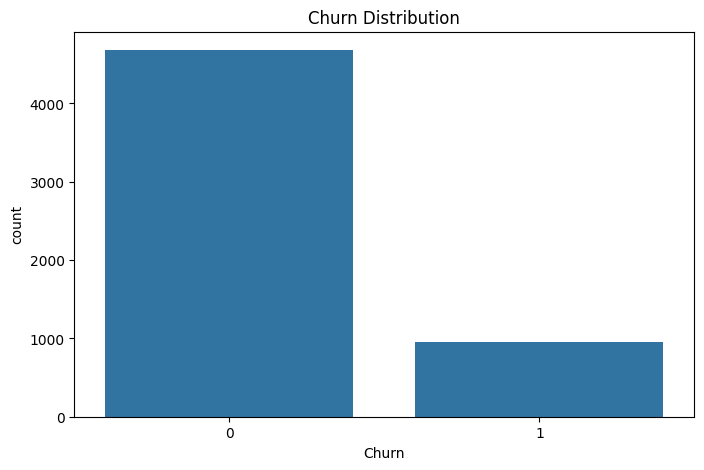

In [ ]:
# Create basic visualizations
# Churn Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution')
plt.show()

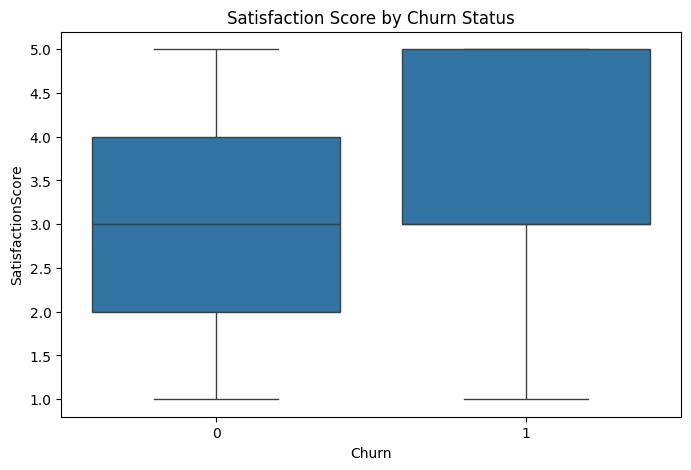

In [ ]:
# Satisfaction Score vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Churn', y='SatisfactionScore')
plt.title('Satisfaction Score by Churn Status')
plt.show()

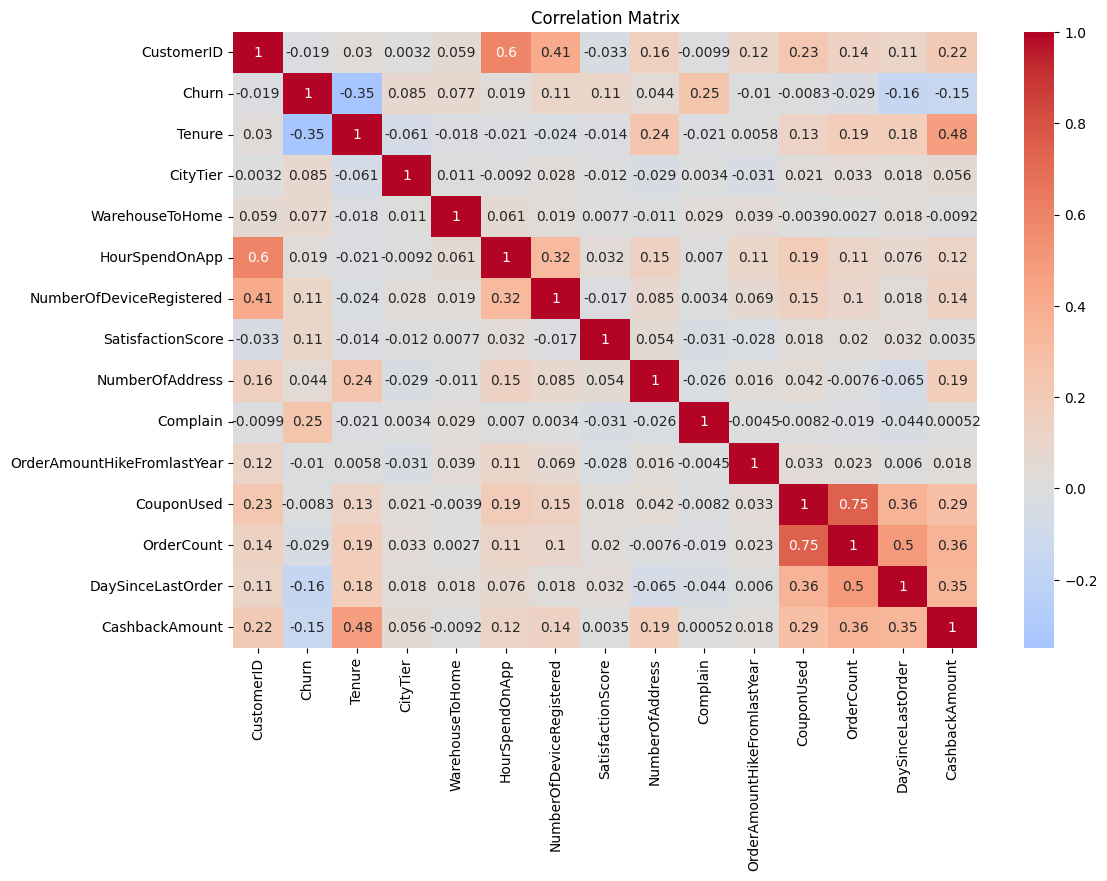

In [ ]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
correlation = df[numerical_features].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

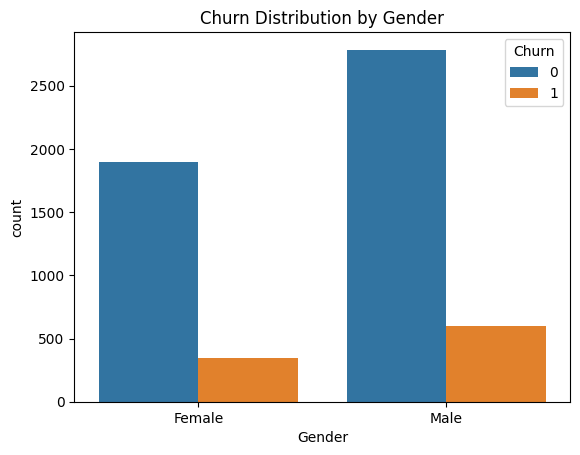

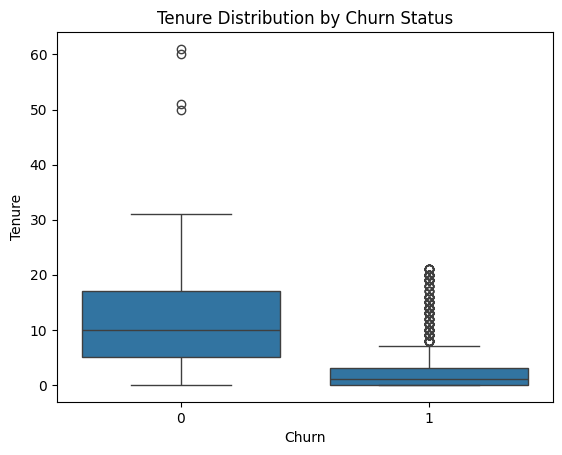

In [ ]:
# Churn vs Gender
sns.countplot(data=df, x='Gender', hue='Churn')
plt.title('Churn Distribution by Gender')
plt.show()

# Churn vs Tenure
sns.boxplot(data=df, x='Churn', y='Tenure')
plt.title('Tenure Distribution by Churn Status')
plt.show()

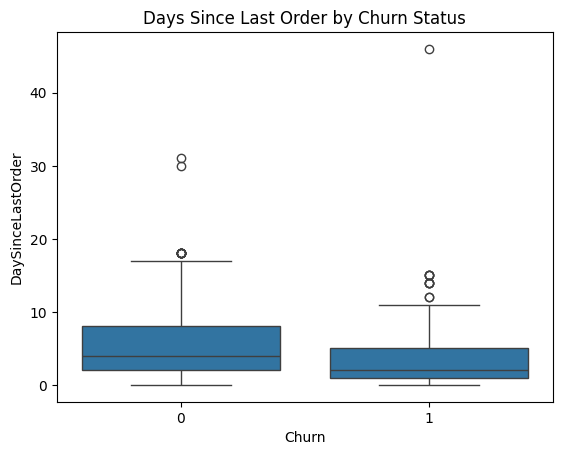

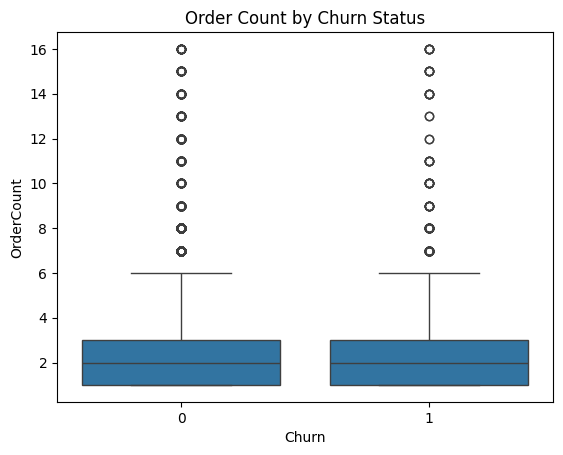

In [ ]:
# Churn vs DaySinceLastOrder
sns.boxplot(data=df, x='Churn', y='DaySinceLastOrder')
plt.title('Days Since Last Order by Churn Status')
plt.show()

# Churn vs OrderCount
sns.boxplot(data=df, x='Churn', y='OrderCount')
plt.title('Order Count by Churn Status')
plt.show()

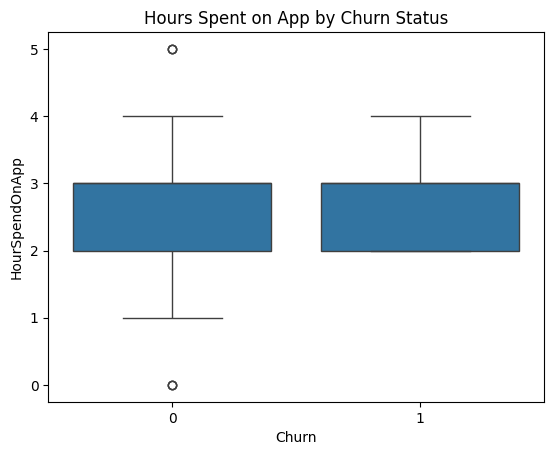

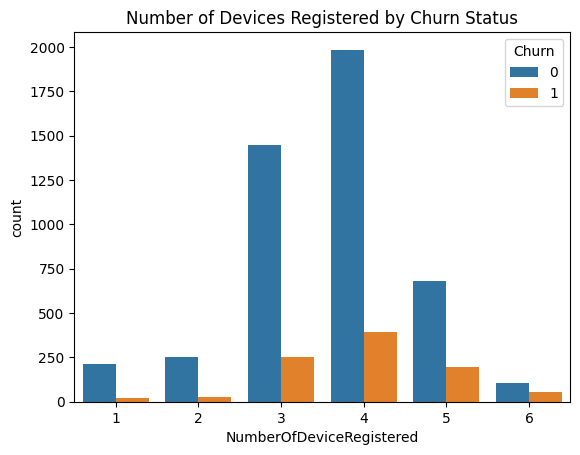

In [ ]:
# Churn vs HourSpendOnApp
sns.boxplot(data=df, x='Churn', y='HourSpendOnApp')
plt.title('Hours Spent on App by Churn Status')
plt.show()

# Churn vs NumberOfDeviceRegistered
sns.countplot(data=df, x='NumberOfDeviceRegistered', hue='Churn')
plt.title('Number of Devices Registered by Churn Status')
plt.show()

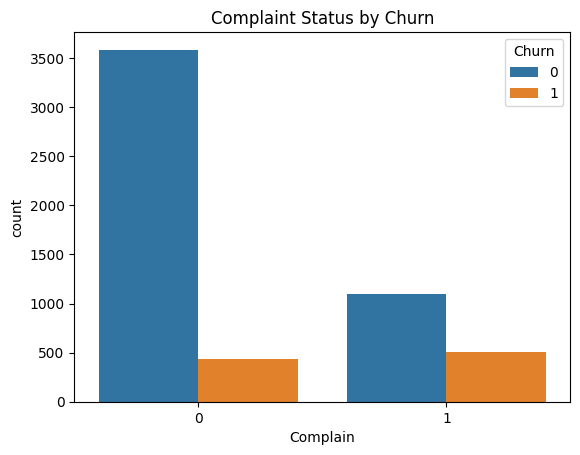

In [ ]:
# Churn vs Complain
sns.countplot(data=df, x='Complain', hue='Churn')
plt.title('Complaint Status by Churn')
plt.show()

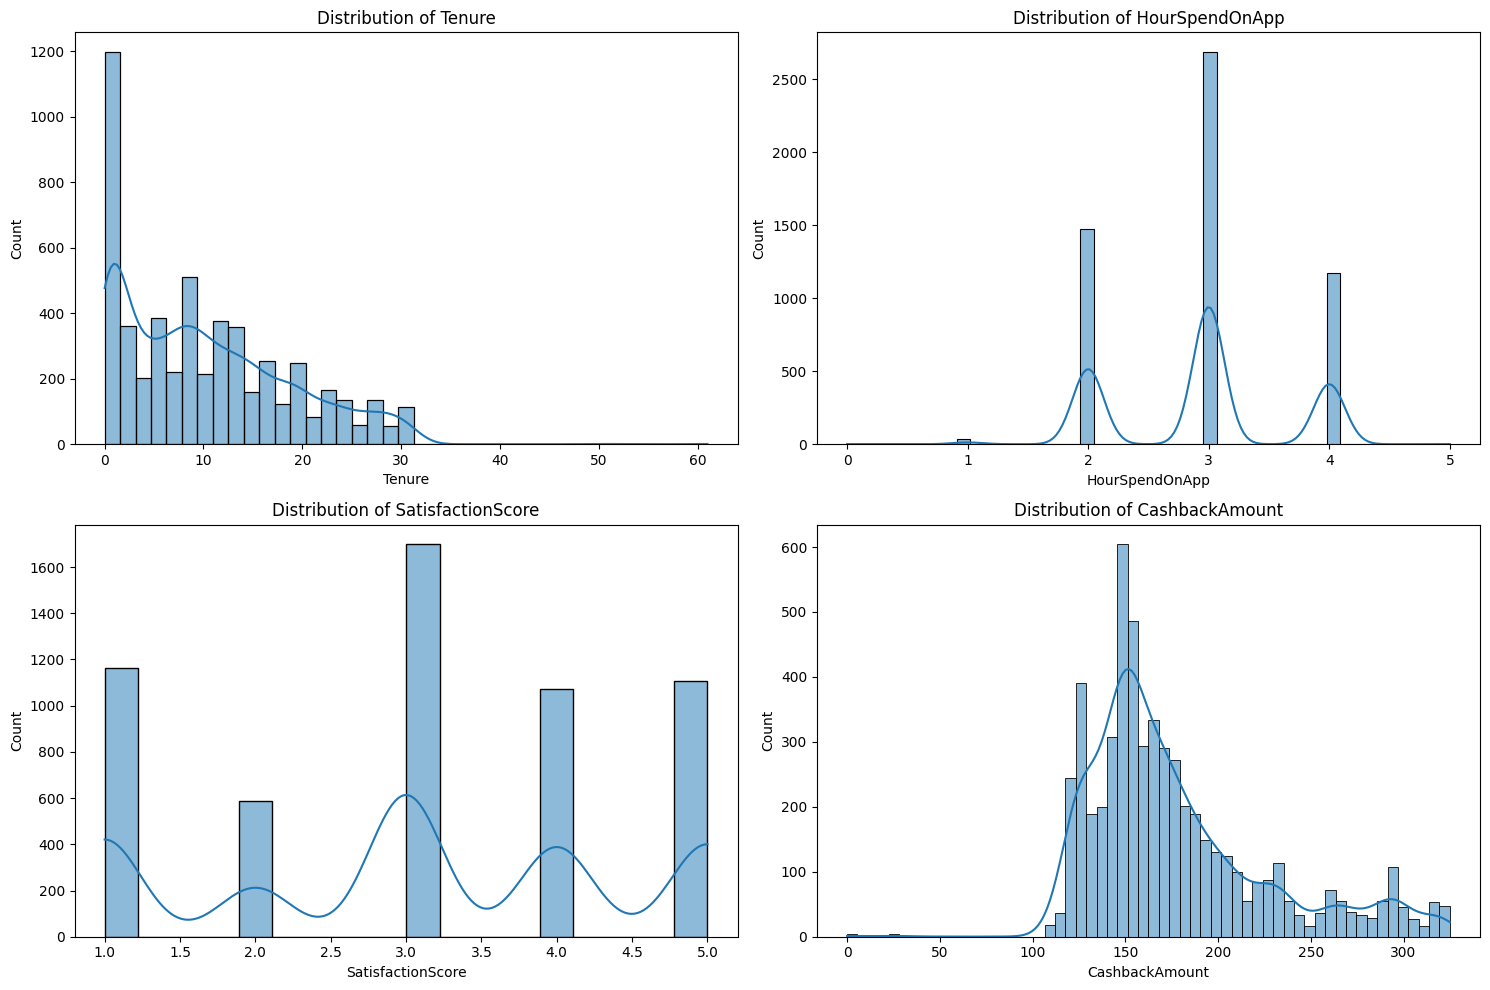

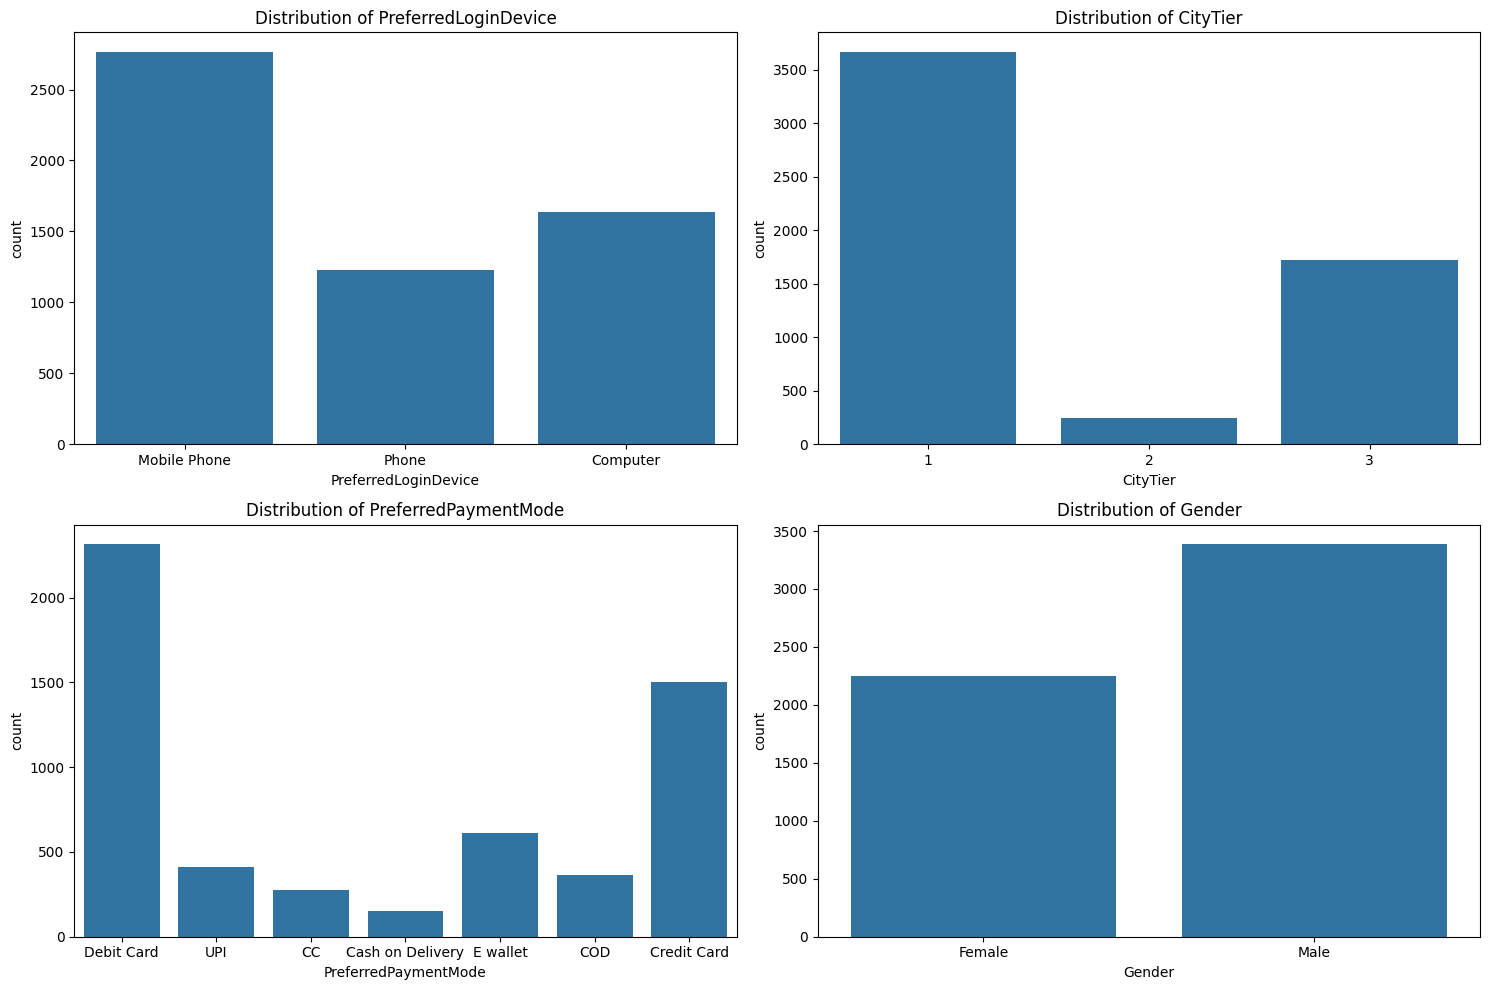

In [ ]:
# Distribution of numerical features
numerical_features = ['Tenure', 'HourSpendOnApp', 'SatisfactionScore', 'CashbackAmount']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Distribution of categorical features
categorical_features = ['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'Gender']
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_features):
    plt.subplot(2, 2, i+1)
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

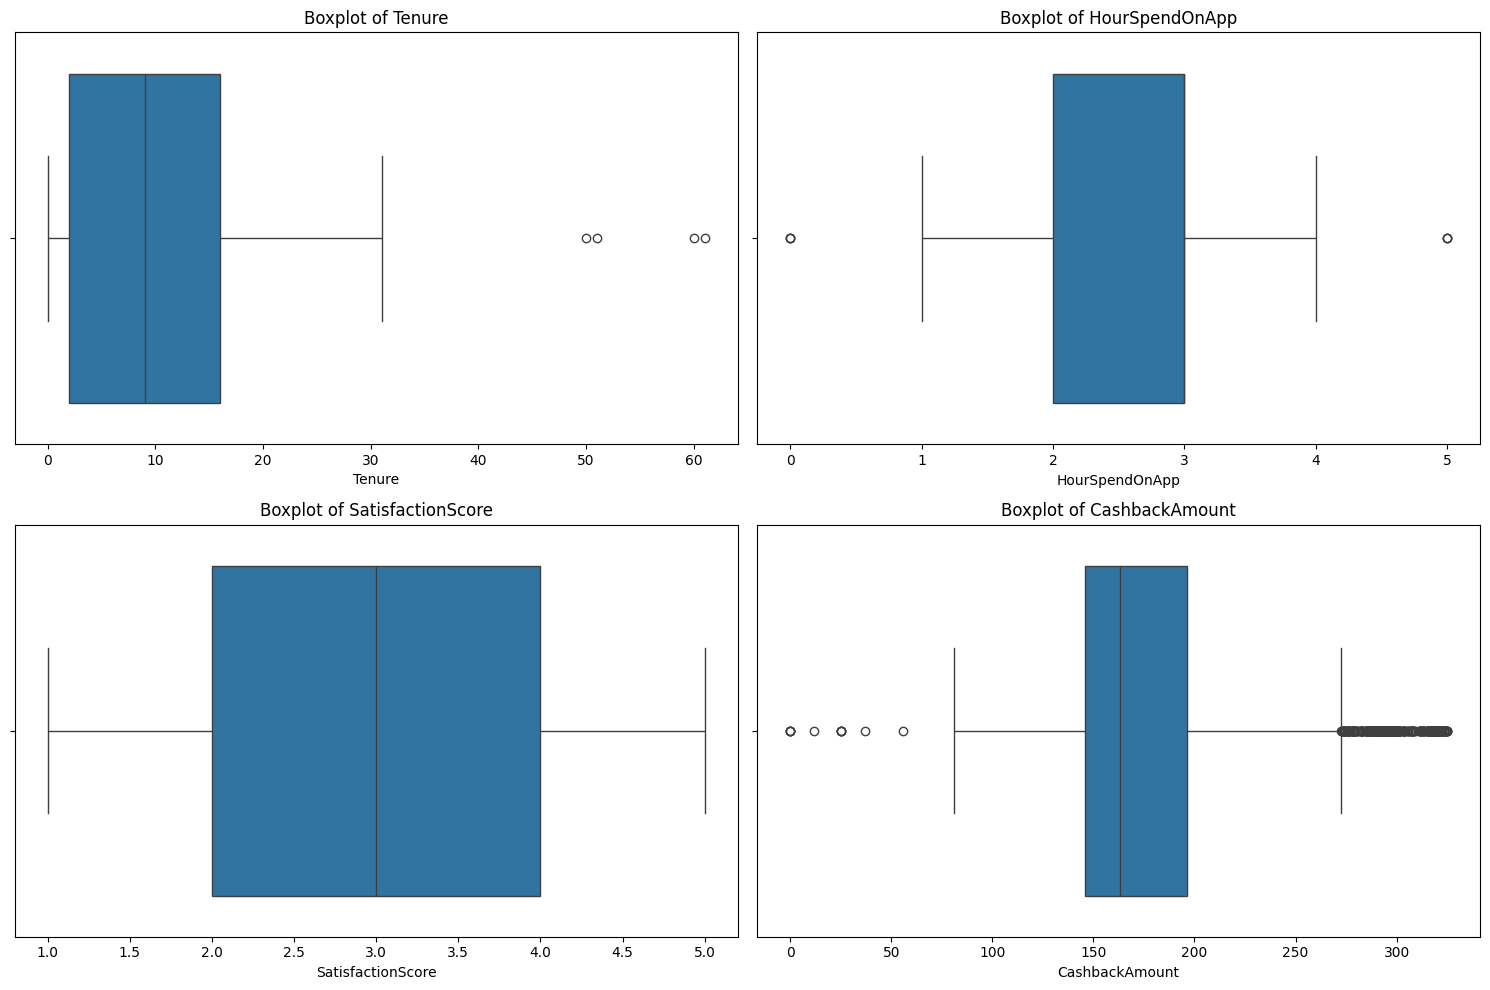

In [ ]:
# Boxplot for numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

## Data Preprocessing

- Handing Missing Value -- Replace with median
- Label Encoding for Object Datatype
- Feature Selection & Correlation Map
- Split the training and testing dataset
- Removing Outlier for training dataset
- Regularization for training dataset -- Scaler

In [ ]:
### Remove CustomerID column
df.drop(columns='CustomerID', inplace=True)

In [ ]:
### Check the missing value
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64


In [ ]:
### Replace the missing value with median
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df['WarehouseToHome'] = df['WarehouseToHome'].fillna(df['WarehouseToHome'].median())
df['HourSpendOnApp'] = df['HourSpendOnApp'].fillna(df['HourSpendOnApp'].median())
df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(df['OrderAmountHikeFromlastYear'].median())
df['CouponUsed'] = df['CouponUsed'].fillna(df['CouponUsed'].median())
df['OrderCount'] = df['OrderCount'].fillna(df['OrderCount'].median())
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].median())

In [ ]:
### Label Encoding for Object Datatype
# Identify the object datatype
df.select_dtypes(include='object').nunique()

PreferredLoginDevice    3
PreferredPaymentMode    7
Gender                  2
PreferedOrderCat        6
MaritalStatus           3
dtype: int64

In [ ]:
# Identify the category column
category_col = df.select_dtypes(include=['object']).columns

# Initialize a LabelEncoder object
label_encoder = LabelEncoder()

# Loop over each column to encoder to the unique value
for col in category_col:

    # Fit the encoder to the unique values in the column
    label_encoder.fit(df[col].unique())

    # Transform the column using the encoder
    df[col] = label_encoder.transform(df[col])

    # Print the column name and the unique encoded values
    print(f"{col}: {df[col].unique()}")

# Display the result
df.head()

PreferredLoginDevice: [1 2 0]
PreferredPaymentMode: [4 6 0 2 5 1 3]
Gender: [0 1]
PreferedOrderCat: [2 3 4 5 0 1]
MaritalStatus: [2 0 1]


Churn  Tenure  PreferredLoginDevice  CityTier  WarehouseToHome  \
0      1     4.0                     1         3              6.0   
1      1     9.0                     2         1              8.0   
2      1     9.0                     2         1             30.0   
3      1     0.0                     2         3             15.0   
4      1     0.0                     2         1             12.0   

   PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0                     4       0             3.0                         3   
1                     6       1             3.0                         4   
2                     4       1             2.0                         4   
3                     4       1             2.0                         4   
4                     0       1             3.0                         3   

   PreferedOrderCat  SatisfactionScore  MaritalStatus  NumberOfAddress  \
0                 2                  2              2                9   
1                 3                  3              2                7   
2                 3                  3              2                6   
3                 2                  5              2                8   
4                 3                  5              2                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                         11.0         1.0         1.0   
1         1                         15.0         0.0         1.0   
2         1                         14.0         0.0         1.0   
3         0                         23.0         0.0         1.0   
4         0                         11.0         1.0         1.0   

   DaySinceLastOrder  CashbackAmount  
0                5.0          159.93  
1                0.0          120.90  
2                3.0          120.28  
3                3.0          134.07  
4                3.0          129.60

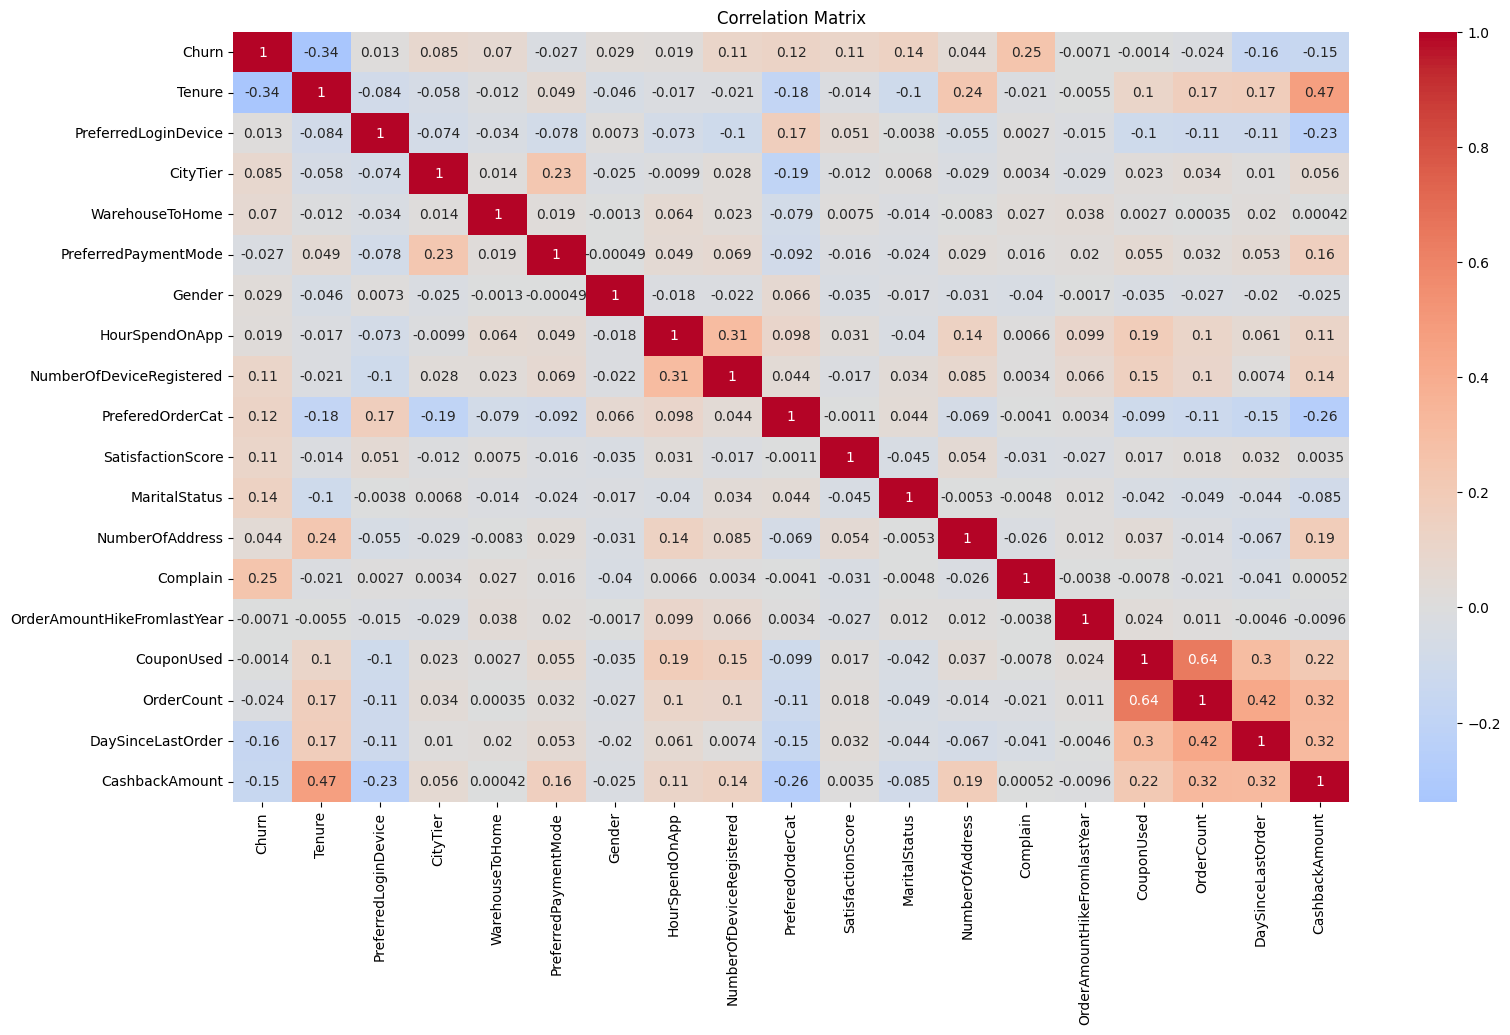

In [ ]:
### Correlation Map
plt.figure(figsize=(18,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

As there is no highly correlated features, we did not drop any features at this stage.

In [ ]:
### Split the training and testing dataset
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Apply SMOTE to the training set only
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Overwrite X_train and y_train with resampled data
X_train, y_train = smote.fit_resample(X_train, y_train)

# Print class distribution before and after SMOTE
print("Class distribution after SMOTE:", Counter(y_train))

Class distribution after SMOTE: Counter({0: 3746, 1: 3746})


In [ ]:
### Regularization
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Churn Prediction & Customer Lifetime Value

### Logistic Regression

In [ ]:
### Baseline model
model_lr = LogisticRegression()

# Train the model
model_lr.fit(X_train_scaled, y_train)

# Make the prediction
y_pred_lr = model_lr.predict(X_test_scaled)

# Baseline Model Evaluation
print("Baseline Model Evaluation:")
print(classification_report(y_test, y_pred_lr))

Baseline Model Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81       936
           1       0.36      0.79      0.49       190

    accuracy                           0.73      1126
   macro avg       0.65      0.75      0.65      1126
weighted avg       0.84      0.73      0.76      1126



In [ ]:
### Lasso Regularization model
model_lr_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)

# Train the model
model_lr_lasso.fit(X_train_scaled, y_train)

# Make the prediction
y_pred_lasso = model_lr_lasso.predict(X_test_scaled)

# Model Evaluation
print("Lasso Regularization Model Evaluation:")
print(classification_report(y_test, y_pred_lasso))

Lasso Regularization Model Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81       936
           1       0.36      0.79      0.49       190

    accuracy                           0.73      1126
   macro avg       0.65      0.75      0.65      1126
weighted avg       0.85      0.73      0.76      1126



In [ ]:
### Ridge Regularization model
model_lr_ridge = LogisticRegression(penalty='l2', solver='liblinear', C=1.0)

# Train the model
model_lr_ridge.fit(X_train_scaled, y_train)

# Make the prediction
y_pred_ridge = model_lr_ridge.predict(X_test_scaled)

# Model Evaluation
print("Ridge Regularization Model Evaluation:")
print(classification_report(y_test, y_pred_lasso))

Ridge Regularization Model Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81       936
           1       0.36      0.79      0.49       190

    accuracy                           0.73      1126
   macro avg       0.65      0.75      0.65      1126
weighted avg       0.85      0.73      0.76      1126



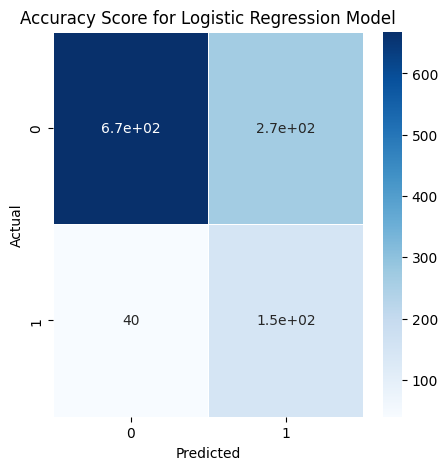

In [ ]:
# Confusion matrix for baseline model
mc_lr = confusion_matrix(y_test, y_pred_lr)

# Show the plot
plt.figure(figsize=(5,5))
sns.heatmap(mc_lr,linewidths=.5, annot=True, cmap = 'Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Accuracy Score for Logistic Regression Model')
plt.show()

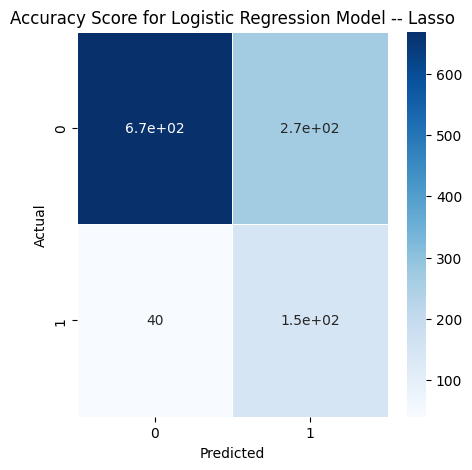

In [ ]:
# Confusion matrix for lasso model
mc_lasso = confusion_matrix(y_test, y_pred_lasso)

# Show the plot
plt.figure(figsize=(5,5))
sns.heatmap(mc_lasso,linewidths=.5, annot=True, cmap = 'Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Accuracy Score for Logistic Regression Model -- Lasso')
plt.show()

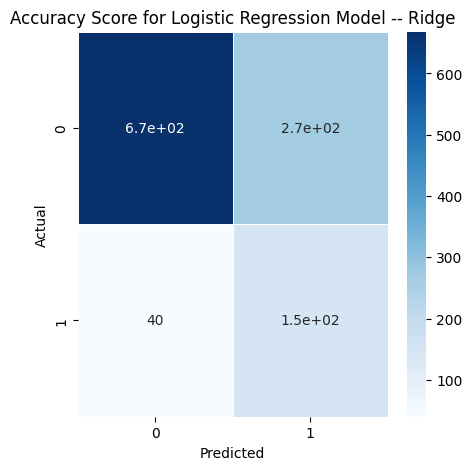

In [ ]:
# Confusion matrix for Ridge model
mc_ridge = confusion_matrix(y_test, y_pred_ridge)

# Show the plot
plt.figure(figsize=(5,5))
sns.heatmap(mc_ridge,linewidths=.5, annot=True, cmap = 'Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Accuracy Score for Logistic Regression Model -- Ridge')
plt.show()

### Support Vector Machine (SVM)


In [ ]:
# SVM with linear kernel
svm_linear = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_linear.fit(X_train_scaled, y_train)

# Predictions and evaluation for linear kernel
y_pred_linear = svm_linear.predict(X_test_scaled)
print("Linear Kernel SVM Performance:")
print(classification_report(y_test, y_pred_linear))

Linear Kernel SVM Performance:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83       936
           1       0.38      0.79      0.51       190

    accuracy                           0.74      1126
   macro avg       0.66      0.76      0.67      1126
weighted avg       0.85      0.74      0.77      1126



In [ ]:
# SVM with RBF kernel (non-linear kernel)
svm_rbf = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)


# Predictions and evaluation for RBF kernel
y_pred_rbf = svm_rbf.predict(X_test_scaled)
print("RBF Kernel SVM Performance:")
print(classification_report(y_test, y_pred_rbf))

RBF Kernel SVM Performance:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       936
           1       0.61      0.87      0.72       190

    accuracy                           0.88      1126
   macro avg       0.79      0.88      0.82      1126
weighted avg       0.91      0.88      0.89      1126



In [ ]:
# Hyperparameter tuning with GridSearchCV for RBF kernel
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf'],  # RBF kernel
}

# Perform grid search
grid_search = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['rbf']},
             verbose=2)

In [ ]:
# Best hyperparameters from GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
# Evaluate the model with the best hyperparameters
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
print("Best SVM Performance (after hyperparameter tuning):")
print(classification_report(y_test, y_pred_best))

# Evaluate accuracy of the best model
accuracy = accuracy_score(y_test, y_pred_best)
print(f"Accuracy of Best SVM: {accuracy:.4f}")

Best SVM Performance (after hyperparameter tuning):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       936
           1       0.88      0.94      0.91       190

    accuracy                           0.97      1126
   macro avg       0.93      0.96      0.94      1126
weighted avg       0.97      0.97      0.97      1126

Accuracy of Best SVM: 0.9680


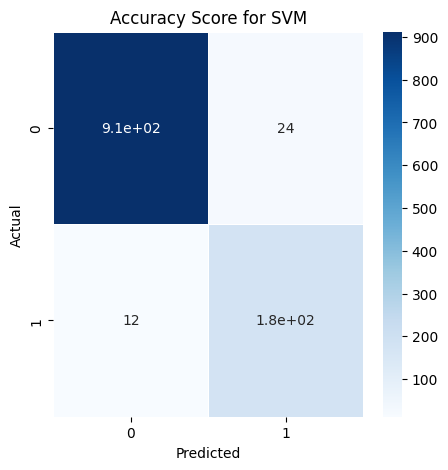

In [ ]:
# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_best)

# Show the plot
plt.figure(figsize=(5,5))
sns.heatmap(cm_svm,linewidths=.5, annot=True, cmap = 'Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Accuracy Score for SVM')
plt.show()

In [ ]:
# Get the summary result for SVM model
# Create a DataFrame with the predictions and original index from X_test
predictions_df = pd.DataFrame(y_pred_best, index=X_test.index, columns=['Predicted_Churn'])

# Calculate the churn rate as the mean of the predicted churn values
churn_rate = predictions_df['Predicted_Churn'].mean()

# Convert to percentage
churn_rate_percentage = churn_rate * 100

# Print the result
print(f"The churn rate is {churn_rate_percentage:.2f}%")

The churn rate is 17.94%


### Tree-based Models


1. Random Forest
- Feature importance analysis
- Compare performance with different tree depths and estimators

In [ ]:
model_rf = RandomForestClassifier(class_weight='balanced')
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'random_state': [0,42]
}

# Perform Gird Search to find the best parameter
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5)
grid_search_rf.fit(X_train_scaled, y_train)

# Print out the best parameter
print("Best Parameters for Random Forest:")
print(grid_search_rf.best_params_)

Best Parameters for Random Forest:
{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 0}


In [ ]:
# Perform the random forest with the best parameter
best_rf = RandomForestClassifier(random_state=0, max_features='sqrt', max_depth =20, n_estimators=200, class_weight='balanced')

# Train the model
best_rf.fit(X_train_scaled, y_train)

# Make the prediction
y_pred_rf = best_rf.predict(X_test_scaled)

# Model Evaluation
print("Random Forest Model Evaluation:")
print(classification_report(y_test, y_pred_rf))

Random Forest Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       936
           1       0.93      0.94      0.93       190

    accuracy                           0.98      1126
   macro avg       0.96      0.96      0.96      1126
weighted avg       0.98      0.98      0.98      1126



                        Feature  Importance
0                        Tenure    0.294762
17               CashbackAmount    0.103827
16            DaySinceLastOrder    0.083017
3               WarehouseToHome    0.065499
13  OrderAmountHikeFromlastYear    0.054482
14                   CouponUsed    0.049033
6                HourSpendOnApp    0.043988
8              PreferedOrderCat    0.043934
11              NumberOfAddress    0.041683
15                   OrderCount    0.036584
9             SatisfactionScore    0.031657
4          PreferredPaymentMode    0.031115
2                      CityTier    0.024445
1          PreferredLoginDevice    0.023090
7      NumberOfDeviceRegistered    0.021712
12                     Complain    0.021657
10                MaritalStatus    0.015636
5                        Gender    0.013879


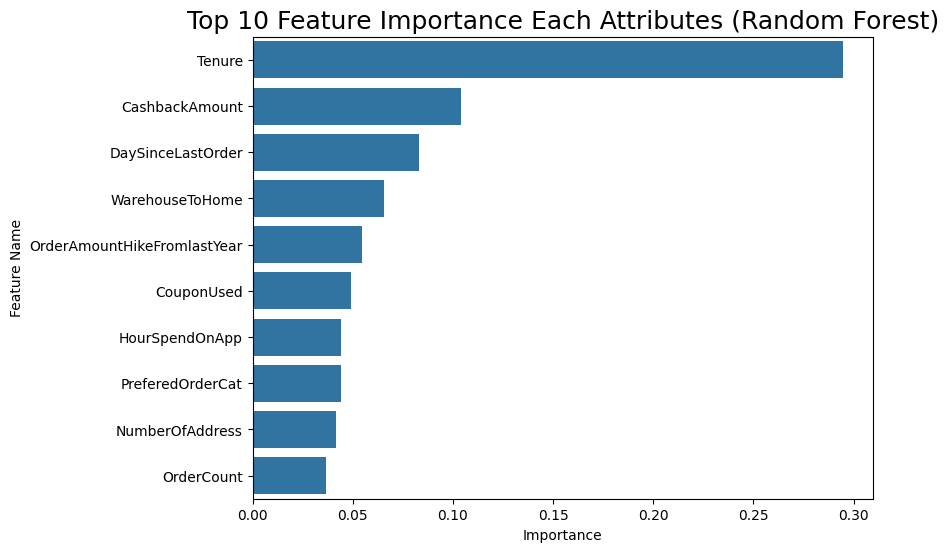

In [ ]:
# Feature importance
ft_imp = best_rf.feature_importances_

# Display feature importance
ft_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': ft_imp
}).sort_values(by='Importance', ascending=False)

# Print the feature importance
print(ft_imp_df)

# Make the plot
ft_imp_df_head = ft_imp_df.head(10)
plt.figure(figsize=(8,6))
sns.barplot(ft_imp_df_head, x='Importance', y='Feature')
plt.title('Top 10 Feature Importance Each Attributes (Random Forest)', fontsize=18)
plt.xlabel ('Importance')
plt.ylabel ('Feature Name')
plt.show()

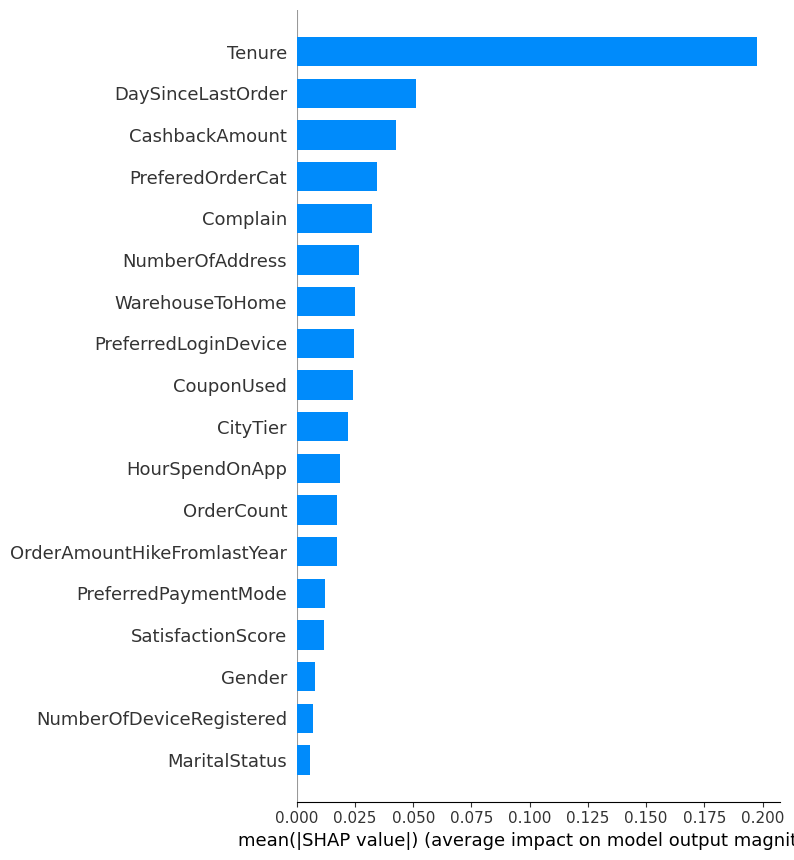

In [ ]:
# SHAP value calculation
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_scaled)

# Plot the SHAP summary
shap.summary_plot(shap_values[:,:,1], X_test_scaled,feature_names=X_test.columns, plot_type = 'bar')

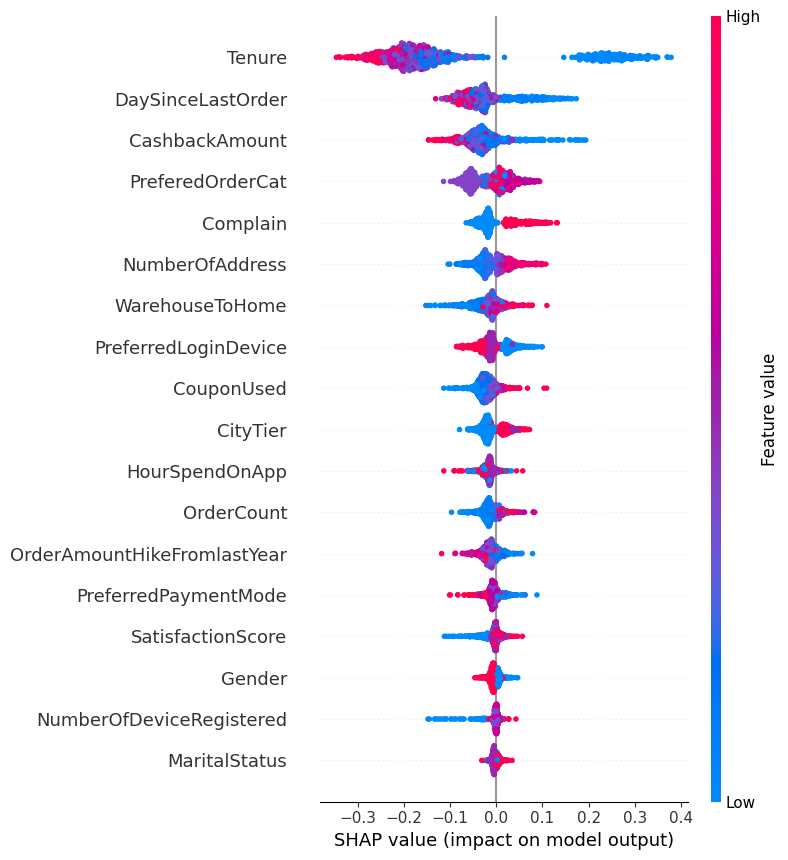

In [ ]:
# Plot the SHAP summary
shap.summary_plot(shap_values[:,:,1], X_test_scaled, feature_names=X_test.columns)

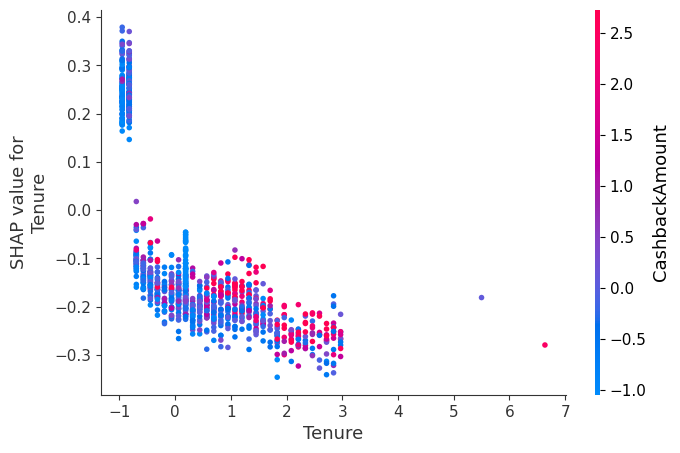

In [ ]:
# Plot the SHAP dependence plot for a specific feature
shap.dependence_plot('Tenure', shap_values[:,:,1], X_test_scaled, feature_names=X_test.columns)

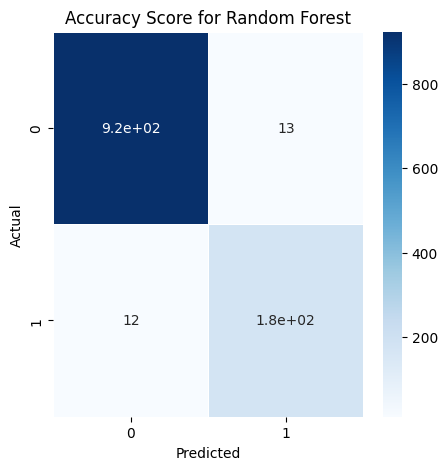

In [ ]:
# Confusion Matrix for Random forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,5))
sns.heatmap(cm_rf,linewidths=.5, annot=True, cmap = 'Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Accuracy Score for Random Forest')
plt.show()

2. XGBoost
- Hyperparameter tuning (learning rate, max depth, subsample)
- SHAP values for model interpretability

In [ ]:
# Define the XGBoost model
model_xg = XGBClassifier()

# Define the parameter grid for grid search
param_grid_xg = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 0.1, 0.2]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search_xg = GridSearchCV(model_xg, param_grid_xg, cv=5)
grid_search_xg.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print(grid_search_xg.best_params_)

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [ ]:
# Perform XG Boost with the best parameter
best_xg = XGBClassifier(gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200)

# Train the model
best_xg.fit(X_train_scaled, y_train)

# Make the prediction
y_pred_xg = best_xg.predict(X_test_scaled)

# Model Evaluation
print("XGBoost Evaluation:")
print(classification_report(y_test, y_pred_xg))

XGBoost Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       936
           1       0.95      0.98      0.96       190

    accuracy                           0.99      1126
   macro avg       0.97      0.98      0.98      1126
weighted avg       0.99      0.99      0.99      1126



                        Feature  Importance
0                        Tenure    0.227385
6                HourSpendOnApp    0.086948
14                   CouponUsed    0.084696
15                   OrderCount    0.069152
12                     Complain    0.055439
8              PreferedOrderCat    0.050691
16            DaySinceLastOrder    0.049972
17               CashbackAmount    0.047256
11              NumberOfAddress    0.042732
2                      CityTier    0.041729
1          PreferredLoginDevice    0.039691
4          PreferredPaymentMode    0.037048
9             SatisfactionScore    0.034950
7      NumberOfDeviceRegistered    0.033102
3               WarehouseToHome    0.029162
10                MaritalStatus    0.024835
13  OrderAmountHikeFromlastYear    0.022693
5                        Gender    0.022518


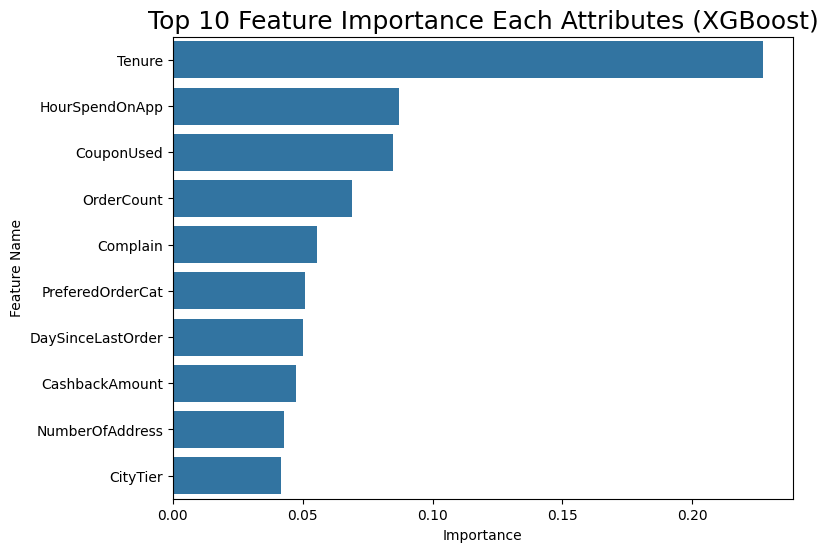

In [ ]:
# Feature importance
ft_imp_xg = best_xg.feature_importances_

# Display feature importance
ft_imp_df_xg = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': ft_imp_xg
}).sort_values(by='Importance', ascending=False)

# Print the feature importance
print(ft_imp_df_xg)

# Make the plot
ft_imp_df_xg_head = ft_imp_df_xg.head(10)
plt.figure(figsize=(8,6))
sns.barplot(ft_imp_df_xg_head, x='Importance', y='Feature')
plt.title('Top 10 Feature Importance Each Attributes (XGBoost)', fontsize=18)
plt.xlabel ('Importance')
plt.ylabel ('Feature Name')
plt.show()

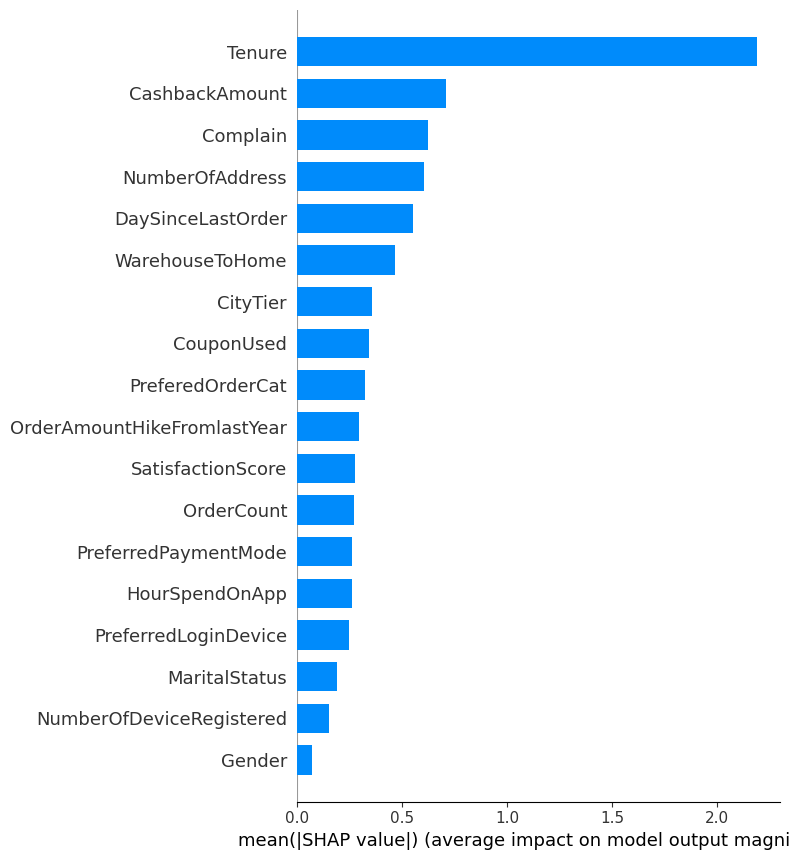

In [ ]:
# SHAP value calculation
explainer = shap.TreeExplainer(best_xg)
shap_values = explainer.shap_values(X_test_scaled)

# Plot the SHAP summary
shap.summary_plot(shap_values, X_test_scaled,feature_names=X_test.columns, plot_type = 'bar')

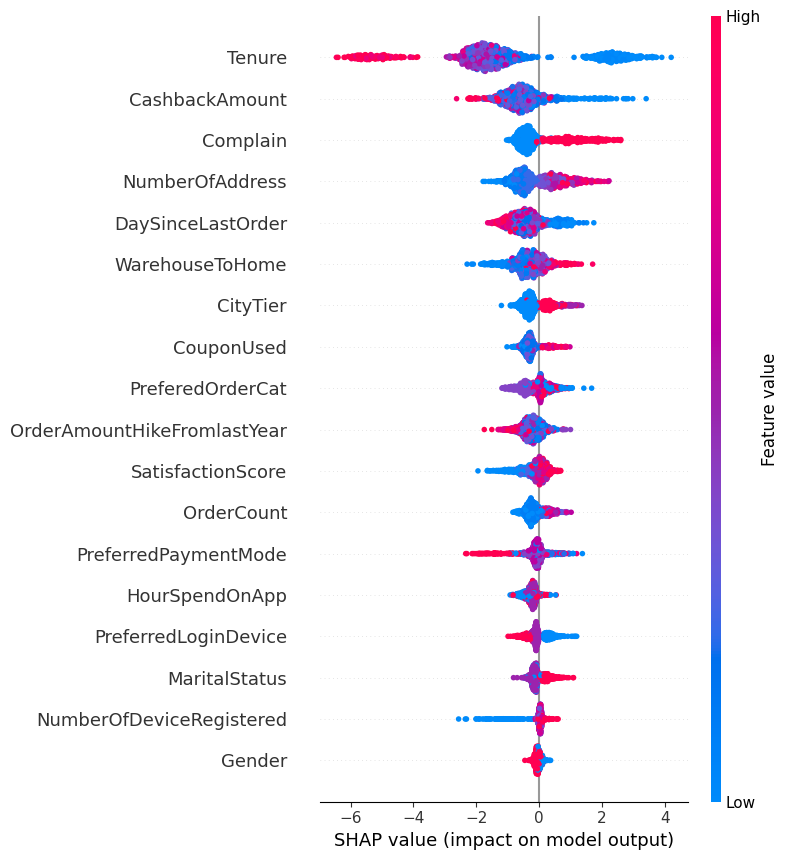

In [ ]:
# Plot the SHAP summary
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

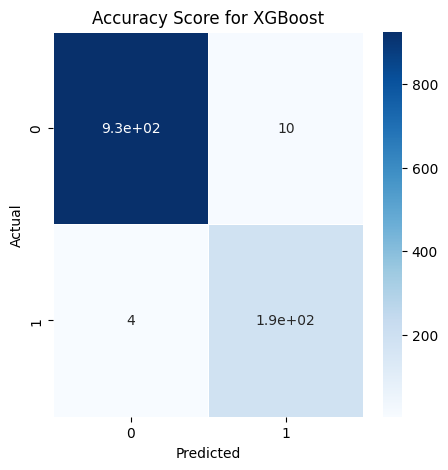

In [ ]:
cm_xg = confusion_matrix(y_test, y_pred_xg)
plt.figure(figsize=(5,5))
sns.heatmap(cm_xg,linewidths=.5, annot=True, cmap = 'Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Accuracy Score for XGBoost')
plt.show()

### Stack Model

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from xgboost import XGBClassifier

In [ ]:
# Defining Base Models for Stacking
# Define comprehensive set of base models combining all approaches
base_models = [
    ('lr', LogisticRegression(solver='liblinear', random_state=42)),
    ('lr_ridge', LogisticRegression(penalty='l2', solver='liblinear', C=1.0)),
    ('rf', RandomForestClassifier(n_estimators=100, max_features='sqrt',
                                 random_state=0, class_weight='balanced')),
    ('svm', SVC(kernel='rbf', C=10, gamma=0.1, probability=True,
               class_weight='balanced', random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
]

# Print base model details
for name, model in base_models:
    print(f"{name}: {type(model).__name__}")

lr: LogisticRegression
lr_ridge: LogisticRegression
rf: RandomForestClassifier
svm: SVC
gb: GradientBoostingClassifier


In [ ]:
# Defining Meta Model
# Use XGBClassifier as meta-model
meta_model = XGBClassifier(random_state=42, eval_metric='logloss')
print(f"Meta Model: {type(meta_model).__name__}")

# Create stacking classifier
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    stack_method='auto',
    n_jobs=-1
)

Meta Model: XGBClassifier


In [ ]:
# Cross-Validation Performance
cv_scores = cross_val_score(stack_model, X_train_scaled, y_train, cv=5, scoring='f1')
print(f"CV F1 Scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

CV F1 Scores: [0.94109397 0.98345467 0.98546896 0.98334444 0.98083278]
Mean CV F1: 0.9748 (±0.0169)


In [ ]:
# Train Final Stack Model
stack_model.fit(X_train_scaled, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(random_state=42,
                                                   solver='liblinear')),
                               ('lr_ridge',
                                LogisticRegression(solver='liblinear')),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       random_state=0)),
                               ('svm',
                                SVC(C=10, class_weight='balanced', gamma=0.1,
                                    probability=True, random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=42, ...),
                   n_jobs=-1)

In [ ]:
# Make Predictions
y_pred_stack = stack_model.predict(X_test_scaled)

In [ ]:
# Stack Model Evaluation
# Model Evaluation using classification report
print("Stack Model Classification Report:")
print(classification_report(y_test, y_pred_stack))

# Calculate metrics individually
stack_accuracy = accuracy_score(y_test, y_pred_stack)
stack_precision = precision_score(y_test, y_pred_stack)
stack_recall = recall_score(y_test, y_pred_stack)
stack_f1 = f1_score(y_test, y_pred_stack)

# Print metrics
print(f"Stacking Model Accuracy: {stack_accuracy:.4f}")
print(f"Stacking Model Precision: {stack_precision:.4f}")
print(f"Stacking Model Recall: {stack_recall:.4f}")
print(f"Stacking Model F1 Score: {stack_f1:.4f}")

Stack Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       936
           1       0.92      0.92      0.92       190

    accuracy                           0.97      1126
   macro avg       0.95      0.95      0.95      1126
weighted avg       0.97      0.97      0.97      1126

Stacking Model Accuracy: 0.9725
Stacking Model Precision: 0.9206
Stacking Model Recall: 0.9158
Stacking Model F1 Score: 0.9182


In [ ]:
# Meta Model Feature Importances
feature_importances = stack_model.final_estimator_.feature_importances_
importance_df = pd.DataFrame({
    'Feature': [f'BaseModel_{i}' for i in range(len(base_models))],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(importance_df)

       Feature  Importance
3  BaseModel_3    0.881831
2  BaseModel_2    0.079232
0  BaseModel_0    0.020483
4  BaseModel_4    0.018454
1  BaseModel_1    0.000000


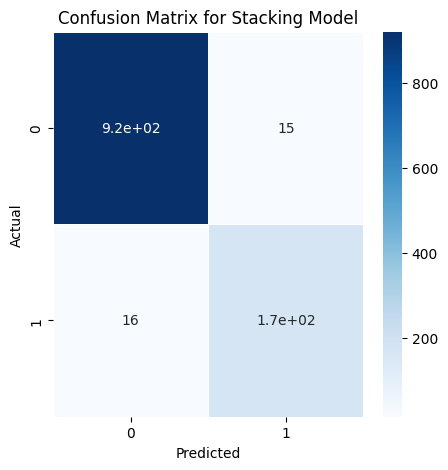

In [ ]:
# Confusion Matrix Visualization
cm_stack = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(5,5))
sns.heatmap(cm_stack, linewidths=.5, annot=True, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Stacking Model')
plt.show()

In [ ]:
# Model Comparison
available_models = []
available_accuracies = []
available_precisions = []
available_recalls = []
available_f1_scores = []

# Add the stacking model
available_models.append('Stacking')
available_accuracies.append(accuracy_score(y_test, y_pred_stack))
available_precisions.append(precision_score(y_test, y_pred_stack))
available_recalls.append(recall_score(y_test, y_pred_stack))
available_f1_scores.append(f1_score(y_test, y_pred_stack))

# Logistic Regression
if 'y_pred_lr' in locals():
    available_models.append('Logistic Regression')
    available_accuracies.append(accuracy_score(y_test, y_pred_lr))
    available_precisions.append(precision_score(y_test, y_pred_lr))
    available_recalls.append(recall_score(y_test, y_pred_lr))
    available_f1_scores.append(f1_score(y_test, y_pred_lr))

# XGBoost
if 'y_pred_xg' in locals():
    available_models.append('XGBoost')
    available_accuracies.append(accuracy_score(y_test, y_pred_xg))
    available_precisions.append(precision_score(y_test, y_pred_xg))
    available_recalls.append(recall_score(y_test, y_pred_xg))
    available_f1_scores.append(f1_score(y_test, y_pred_xg))

# SVM
if 'y_pred_best' in locals():
    available_models.append('SVM')
    available_accuracies.append(accuracy_score(y_test, y_pred_best))
    available_precisions.append(precision_score(y_test, y_pred_best))
    available_recalls.append(recall_score(y_test, y_pred_best))
    available_f1_scores.append(f1_score(y_test, y_pred_best))

# Random Forest
if 'y_pred_rf' in locals():
    available_models.append('Random Forest')
    available_accuracies.append(accuracy_score(y_test, y_pred_rf))
    available_precisions.append(precision_score(y_test, y_pred_rf))
    available_recalls.append(recall_score(y_test, y_pred_rf))
    available_f1_scores.append(f1_score(y_test, y_pred_rf))

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': available_models,
    'Accuracy': available_accuracies,
    'Precision': available_precisions,
    'Recall': available_recalls,
    'F1 Score': available_f1_scores
})

print("Model Comparison:")
print(comparison_df)

Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
0             Stacking  0.972469   0.920635  0.915789  0.918206
1  Logistic Regression  0.726465   0.358852  0.789474  0.493421
2              XGBoost  0.987567   0.948980  0.978947  0.963731
3                  SVM  0.968028   0.881188  0.936842  0.908163
4        Random Forest  0.977798   0.931937  0.936842  0.934383


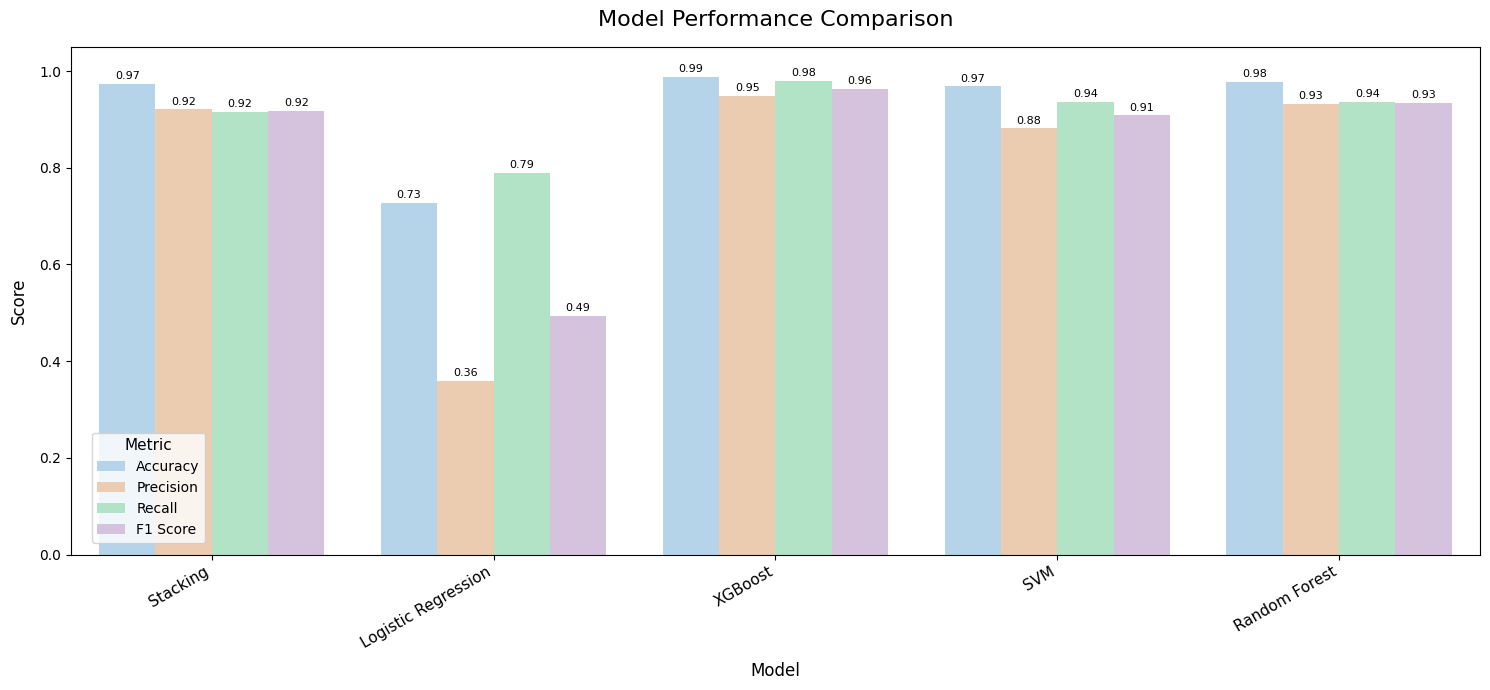

In [ ]:
# 10. Create a single comprehensive bar chart with all models
plt.figure(figsize=(15, 7))

# Melt the dataframe for easier plotting
melted_df = pd.melt(comparison_df, id_vars=['Model'],
                    value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                    var_name='Metric', value_name='Score')

# Define pastel colors for a more pleasing aesthetic
pastel_colors = {
    'Accuracy': '#AED6F1',
    'Precision': '#F5CBA7',
    'Recall': '#ABEBC6',
    'F1 Score': '#D7BDE2'
}

# Create grouped bar chart with custom pastel colors
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=melted_df,
                palette=pastel_colors)

# Customize appearance
plt.title('Model Performance Comparison', fontsize=16, pad=15)
plt.xlabel('Model', fontsize=12, labelpad=8)
plt.ylabel('Score', fontsize=12, labelpad=8)
plt.xticks(rotation=30, ha='right', fontsize=11)
plt.yticks(fontsize=10)
plt.ylim(0, 1.05)

# Set Y-axis to display fewer ticks, making the chart appear more compact
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Move legend to inside the chart to save space
plt.legend(title='Metric', fontsize=10, title_fontsize=11,
          loc='lower left', bbox_to_anchor=(0.01, 0.01))

# Use smaller font for value labels
for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0.2:
        ax.text(p.get_x() + p.get_width()/2., height + 0.01, f'{height:.2f}',
                ha='center', fontsize=8)

# Ensure all elements fit properly in the chart
plt.tight_layout()
plt.show()

### Customer Lifetime Value (CLV)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap

In [ ]:
# Data Preparation & Basic CLV Calculation
# Create a copy of the dataframe for CLV analysis
df_clv = df.copy()

# Calculate Average Order Value using OrderAmountHikeFromlastYear as a proxy
df_clv['EstimatedOrderValue'] = 100 * (1 + df_clv['OrderAmountHikeFromlastYear']/100)
print("Estimated Order Value statistics:")
print(df_clv['EstimatedOrderValue'].describe())

# Calculate Customer Value
df_clv['CustomerValue'] = df_clv['EstimatedOrderValue'] * df_clv['OrderCount']
print("\nCustomer Value statistics:")
print(df_clv['CustomerValue'].describe())

# Normalize Tenure to yearly values
df_clv['YearlyTenure'] = df_clv['Tenure'] / 12
print("\nCustomer Lifespan (Years) statistics:")
print(df_clv['YearlyTenure'].describe())

Estimated Order Value statistics:
count    5630.000000
mean      115.674600
std         3.591058
min       111.000000
25%       113.000000
50%       115.000000
75%       118.000000
max       126.000000
Name: EstimatedOrderValue, dtype: float64

Customer Value statistics:
count    5630.000000
mean      342.715631
std       333.467832
min       111.000000
25%       119.000000
50%       230.000000
75%       345.000000
max      2016.000000
Name: CustomerValue, dtype: float64

Customer Lifespan (Years) statistics:
count    5630.000000
mean        0.844509
std         0.696496
min         0.000000
25%         0.250000
50%         0.750000
75%         1.250000
max         5.083333
Name: YearlyTenure, dtype: float64


In [ ]:
# Comprehensive CLV Calculation
df_clv['CLV'] = df_clv['CustomerValue'] * df_clv['YearlyTenure']
print("CLV statistics:")
print(df_clv['CLV'].describe())

CLV statistics:
count    5630.000000
mean      327.869124
std       532.491687
min         0.000000
25%        47.083333
50%       150.958333
75%       373.333333
max      4766.250000
Name: CLV, dtype: float64


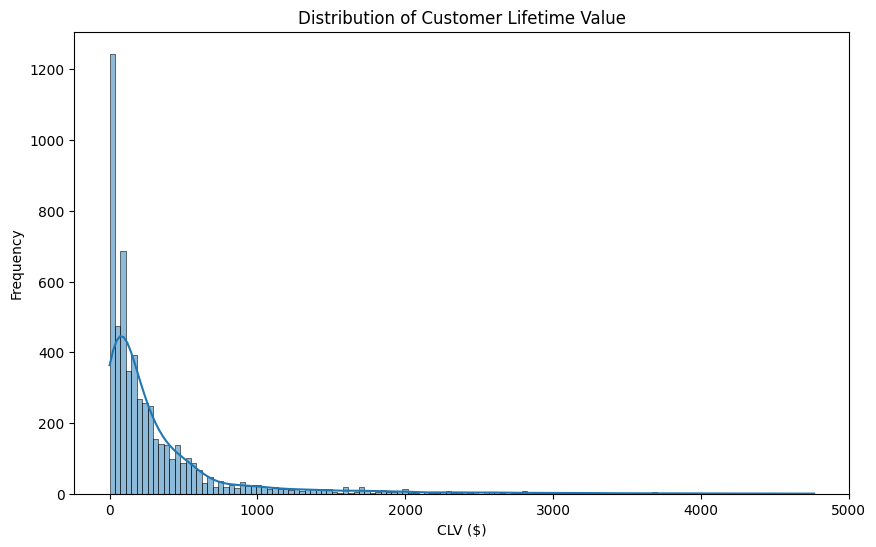

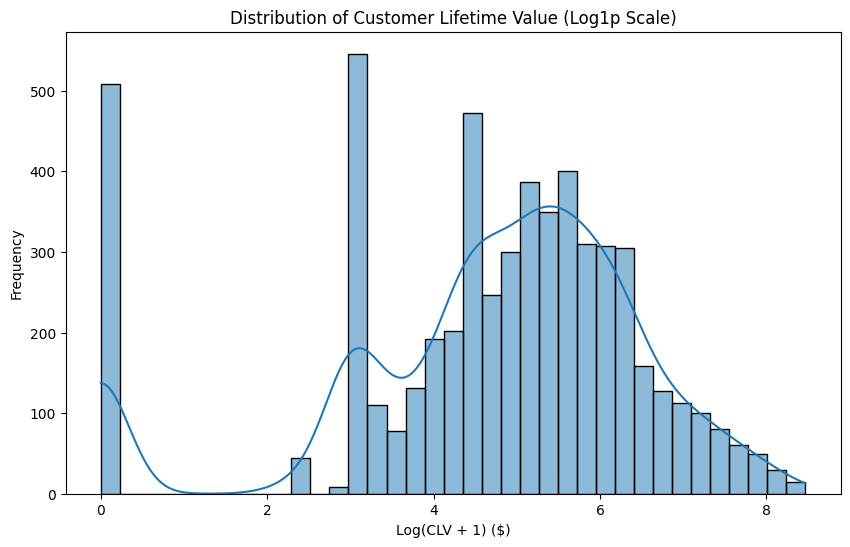

In [ ]:
# Visualize CLV Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_clv['CLV'], kde=True)
plt.title('Distribution of Customer Lifetime Value')
plt.xlabel('CLV ($)')
plt.ylabel('Frequency')
plt.show()

# Use np.log1p to take the log of CLV
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df_clv['CLV']), kde=True)
plt.title('Distribution of Customer Lifetime Value (Log1p Scale)')
plt.xlabel('Log(CLV + 1) ($)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# CLV Segmentation
# Define quartiles for segmentation
q25 = df_clv['CLV'].quantile(0.25)
q50 = df_clv['CLV'].quantile(0.50)
q75 = df_clv['CLV'].quantile(0.75)

# Create customer segments
df_clv['CLV_Segment'] = 'Low'
df_clv.loc[df_clv['CLV'] > q25, 'CLV_Segment'] = 'Medium-Low'
df_clv.loc[df_clv['CLV'] > q50, 'CLV_Segment'] = 'Medium-High'
df_clv.loc[df_clv['CLV'] > q75, 'CLV_Segment'] = 'High'

print("CLV segmentation boundaries:")
print(f"Low: <= ${q25:.2f}")
print(f"Medium-Low: ${q25:.2f} - ${q50:.2f}")
print(f"Medium-High: ${q50:.2f} - ${q75:.2f}")
print(f"High: > ${q75:.2f}")

# Count customers in each segment
segment_counts = df_clv['CLV_Segment'].value_counts()
print("\nCustomer count by CLV segment:")
print(segment_counts)

CLV segmentation boundaries:
Low: <= $47.08
Medium-Low: $47.08 - $150.96
Medium-High: $150.96 - $373.33
High: > $373.33

Customer count by CLV segment:
CLV_Segment
Medium-High    1417
Low            1415
Medium-Low     1400
High           1398
Name: count, dtype: int64


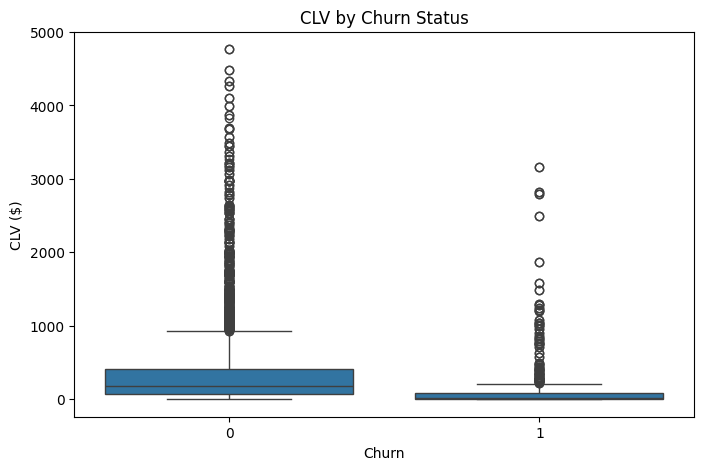

Average CLV by Churn Status:
Churn
0    367.603766
1    131.626934
Name: CLV, dtype: float64

Churn rate by CLV segment:
CLV_Segment
High            5.436338
Low            42.332155
Medium-High     5.645730
Medium-Low     13.785714
Name: Churn, dtype: float64


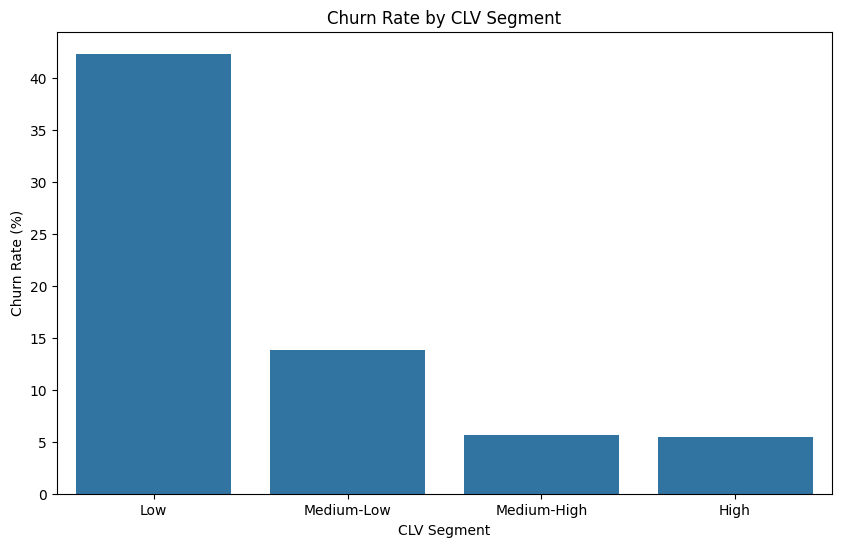

In [ ]:
# Churn Analysis by CLV Segment
# Compare CLV for churned vs non-churned customers
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='CLV', data=df_clv)
plt.title('CLV by Churn Status')
plt.xlabel('Churn')
plt.ylabel('CLV ($)')
plt.show()

# Calculate average CLV by churn status
print("Average CLV by Churn Status:")
print(df_clv.groupby('Churn')['CLV'].mean())

# Calculate churn rate by CLV segment
churn_by_segment = df_clv.groupby('CLV_Segment')['Churn'].mean() * 100
print("\nChurn rate by CLV segment:")
print(churn_by_segment)

# Visualize churn rate by CLV segment
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_by_segment.index, y=churn_by_segment.values, order=['Low', 'Medium-Low', 'Medium-High', 'High'])
plt.title('Churn Rate by CLV Segment')
plt.xlabel('CLV Segment')
plt.ylabel('Churn Rate (%)')
plt.show()

In [ ]:
# High-Value Customer Identification
# Create a flag for high-value customers
high_value_threshold = q75  # Using the 75th percentile as threshold for high value
df_clv['HighValue'] = df_clv['CLV'] > high_value_threshold

# Create test set with CLV data and use existing churn model predictions
print("Using existing churn model predictions to identify high-value customers at risk...")

# Create test set with CLV data
X_test_with_clv = X_test.copy()
X_test_with_clv['CLV'] = df_clv.loc[X_test.index, 'CLV']
X_test_with_clv['HighValue'] = df_clv.loc[X_test.index, 'HighValue']

# Add your existing churn predictions - using the best model
X_test_with_clv['PredictedChurn'] = y_pred_xg

# Identify high-value customers predicted to churn
high_value_at_risk = X_test_with_clv[(X_test_with_clv['HighValue'] == True) & (X_test_with_clv['PredictedChurn'] == 1)]

# Calculate metrics
print(f"Number of high-value customers in the test set: {X_test_with_clv['HighValue'].sum()}")
print(f"Number of high-value customers predicted to churn: {len(high_value_at_risk)}")
print(f"Percentage of high-value customers predicted to churn: {len(high_value_at_risk) / X_test_with_clv['HighValue'].sum() * 100:.2f}%")

# Calculate potential revenue loss
potential_loss = high_value_at_risk['CLV'].sum()
print(f"\nPotential CLV loss from high-value customer churn: ${potential_loss:.2f}")

# Display the first few high-value at-risk customers
print("\nSample of high-value customers at risk of churning:")
print(high_value_at_risk[['CLV', 'PredictedChurn']].head(10))

# Count all high-value customers
total_high_value = df_clv['HighValue'].sum()
print(f"Total number of high-value customers (CLV > ${high_value_threshold:.2f}): {total_high_value}")

Using existing churn model predictions to identify high-value customers at risk...
Number of high-value customers in the test set: 283
Number of high-value customers predicted to churn: 17
Percentage of high-value customers predicted to churn: 6.01%

Potential CLV loss from high-value customer churn: $20776.83

Sample of high-value customers at risk of churning:
              CLV  PredictedChurn
2825   766.666667               1
2549   712.250000               1
3665   747.333333               1
2834   991.666667               1
4755  2817.500000               1
10     575.000000               1
4939   423.750000               1
4249   487.500000               1
2568  1295.000000               1
3285  2817.500000               1
Total number of high-value customers (CLV > $373.33): 1398


Number of high-value customers at risk for sensitivity analysis: 17
Average CLV of high-value at-risk customers: $1222.17


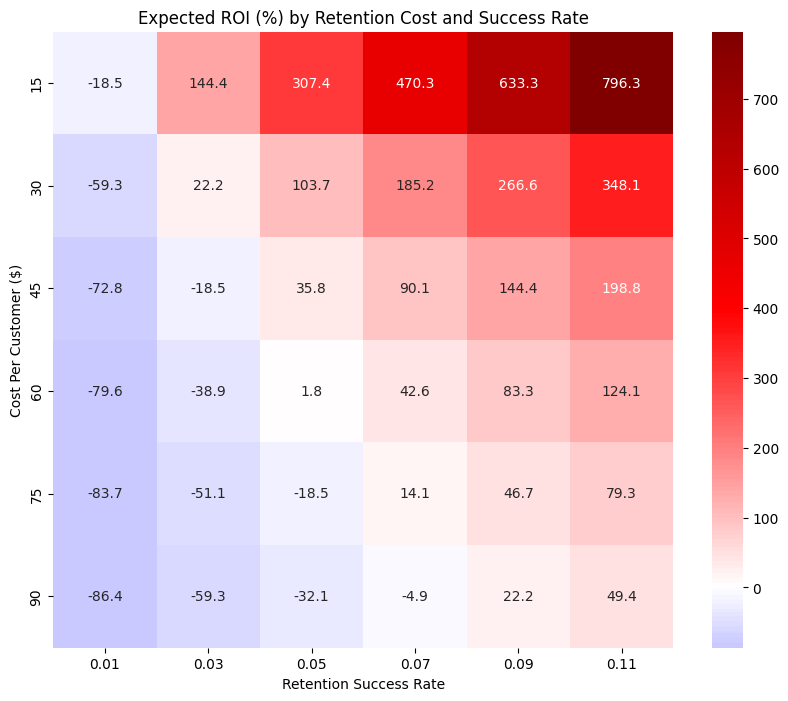

In [ ]:
# 7. Sensitivity Analysis for Retention Campaign

# Create a retention cost-benefit visualization
success_rates = np.array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11])
costs_per_customer = np.array([15, 30, 45, 60, 75, 90])

# Use the number of high-value customers at risk from previous analysis
num_targeted_for_sensitivity = len(high_value_at_risk)
print(f"Number of high-value customers at risk for sensitivity analysis: {num_targeted_for_sensitivity}")

# Calculate the average CLV of high-value at-risk customers (repeat calculation to ensure variable exists)
high_value_at_risk_avg_clv = high_value_at_risk['CLV'].mean()
print(f"Average CLV of high-value at-risk customers: ${high_value_at_risk_avg_clv:.2f}")

roi_results = []
for rate in success_rates:
    for cost in costs_per_customer:
        total_cost = num_targeted_for_sensitivity * cost
        saved = num_targeted_for_sensitivity * rate * high_value_at_risk_avg_clv
        roi = (saved - total_cost) / total_cost * 100
        roi_results.append({
            'Retention Rate': rate,
            'Cost Per Customer': cost,
            'ROI': roi
        })

roi_df = pd.DataFrame(roi_results)

plt.figure(figsize=(10, 8))
roi_pivot = roi_df.pivot(index='Cost Per Customer', columns='Retention Rate', values='ROI')
sns.heatmap(roi_pivot, annot=True, cmap='seismic', center=0, fmt='.1f')
plt.title('Expected ROI (%) by Retention Cost and Success Rate')
plt.xlabel('Retention Success Rate')
plt.ylabel('Cost Per Customer ($)')
plt.show()

## Customer Segmentation

### K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import pandas as pd

In [ ]:
# Split the training and testing dataset without SMOTE
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Double check the training set and testing set
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4504, 19)
(1126, 19)
(4504,)
(1126,)


In [ ]:
# 1. Feature Selection
selected_features = [
    'Tenure', 'HourSpendOnApp', 'OrderCount', 'CouponUsed',
    'DaySinceLastOrder', 'OrderAmountHikeFromlastYear',
    'SatisfactionScore', 'Complain', 'CityTier',
    'NumberOfDeviceRegistered', 'NumberOfAddress', 'CashbackAmount'
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
# 2. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

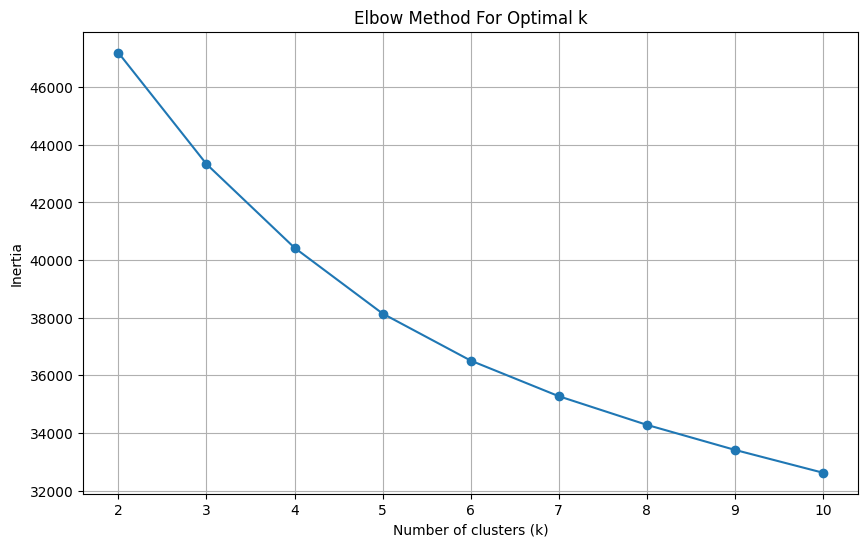

Silhouette Score for k=2: 0.176
Silhouette Score for k=3: 0.122
Silhouette Score for k=4: 0.098
Silhouette Score for k=5: 0.100
Silhouette Score for k=6: 0.097
Silhouette Score for k=7: 0.090
Silhouette Score for k=8: 0.095
Silhouette Score for k=9: 0.093
Silhouette Score for k=10: 0.098


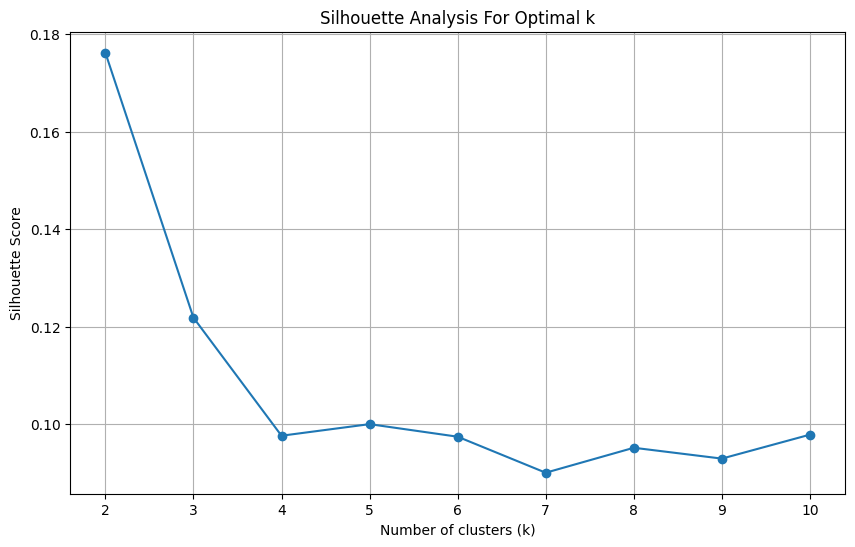

In [ ]:
# 3. Determine optimal number of clusters

# Method 1: Elbow Method
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# Method 2: Silhouette Score
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    score = silhouette_score(X_train_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f'Silhouette Score for k={k}: {score:.3f}')

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.grid(True)
plt.show()

Optimal K from both Elbow Method and Sihouette Analysis are k=4

In [ ]:
# 4. Apply K-means with the optimal k
optimal_k = 4  # Replace with your determined optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_train_scaled)

# 5. Get cluster assignments for training data
train_clusters = kmeans_final.labels_

# 6. Predict clusters for test data
test_clusters = kmeans_final.predict(X_test_scaled)

# 7. Add cluster information back to original data for analysis
X_train['Cluster'] = train_clusters
X_test['Cluster'] = test_clusters

Selected 11 principal components


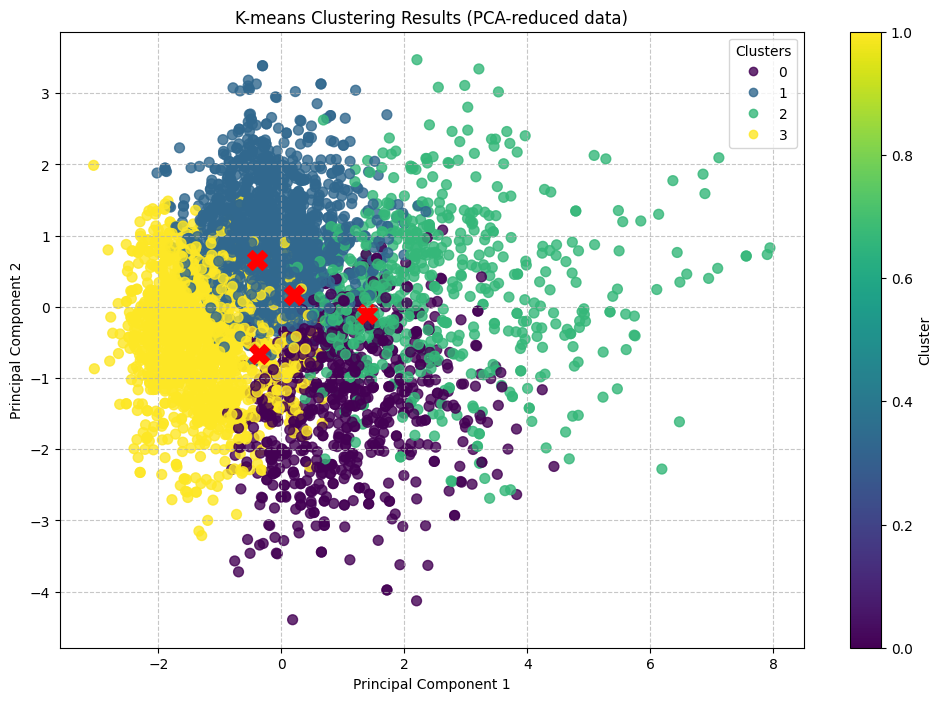

In [ ]:
# 8. Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
print(f"Selected {X_train_pca.shape[1]} principal components")

# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis', s=50, alpha=0.8)
plt.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('K-means Clustering Results (PCA-reduced data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.colorbar(label="Cluster")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Cluster Profiles:
            Tenure  HourSpendOnApp  OrderCount  CouponUsed  DaySinceLastOrder  \
Cluster                                                                         
0        21.760417        2.865885    2.515625    1.428385           5.644531   
1         6.822850        3.399872    2.260591    1.561617           3.690629   
2        11.886139        3.054455    8.587459    4.962046           8.089109   
3         7.049618        2.463740    1.599237    0.765267           3.233461   

         OrderAmountHikeFromlastYear  SatisfactionScore  Complain  CityTier  \
Cluster                                                                       
0                          15.479167           3.067708  0.276042  1.515625   
1                          16.589217           3.155327  0.281130  1.726573   
2                          15.463696           3.118812  0.277228  1.759076   
3                          14.971374           2.959924  0.282443  1.640585   

         NumberOfDe

<Figure size 1200x800 with 0 Axes>

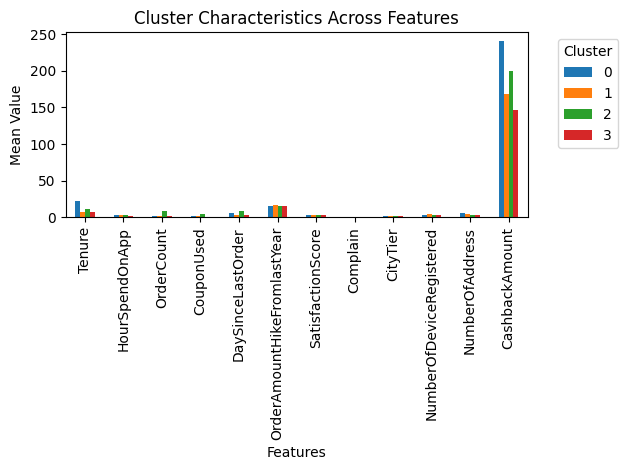

In [ ]:
# 9. Analyze cluster profiles
cluster_profiles = X_train.groupby('Cluster')[selected_features].mean()
print("\nCluster Profiles:")
print(cluster_profiles)

# Visualize cluster characteristics with bar chart
plt.figure(figsize=(12, 8))
cluster_profiles.T.plot(kind='bar')
plt.title('Cluster Characteristics Across Features')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Churn Rate by Cluster (%):
Churn            0          1
Cluster                      
0        97.135417   2.864583
1        76.572529  23.427471
2        85.148515  14.851485
3        82.124682  17.875318


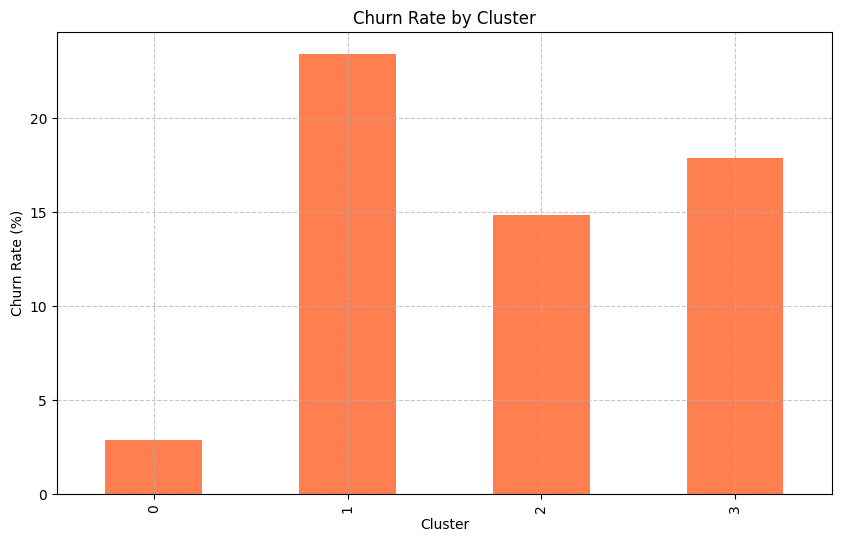

In [ ]:
# 10. Analyze relationship between clusters and target variable
if 'Churn' == y_train.name:
    churn_by_cluster = pd.crosstab(X_train['Cluster'], y_train, normalize='index') * 100
    print("\nChurn Rate by Cluster (%):")
    print(churn_by_cluster)

    # Visualize churn rate by cluster
    plt.figure(figsize=(10, 6))
    churn_by_cluster[1].plot(kind='bar', color='coral')
    plt.title('Churn Rate by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Churn Rate (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


Cluster Distribution - PreferredLoginDevice:
PreferredLoginDevice         0         1         2
Cluster                                           
0                     0.234375  0.736979  0.028646
1                     0.299743  0.527599  0.172657
2                     0.320132  0.589109  0.090759
3                     0.297074  0.294529  0.408397


<Figure size 1200x600 with 0 Axes>

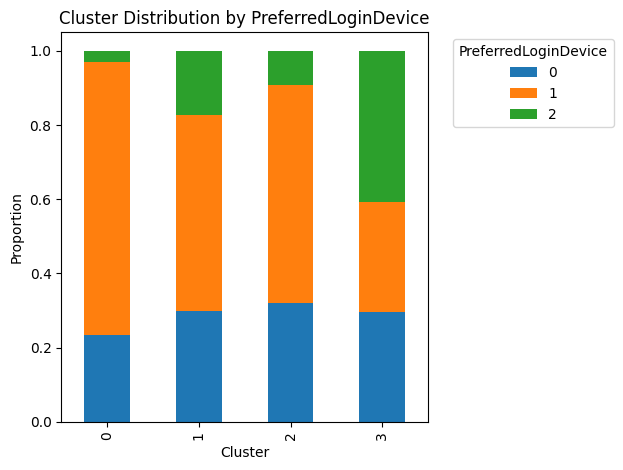


Cluster Distribution - PreferredPaymentMode:
PreferredPaymentMode         0         1         2         3         4  \
Cluster                                                                  
0                     0.002604  0.028646  0.052083  0.337240  0.406250   
1                     0.012195  0.071245  0.014121  0.286906  0.420411   
2                     0.013201  0.057756  0.039604  0.297030  0.407591   
3                     0.119593  0.076336  0.018448  0.197201  0.400763   

PreferredPaymentMode         5         6  
Cluster                                   
0                     0.109375  0.063802  
1                     0.121309  0.073813  
2                     0.118812  0.066007  
3                     0.105598  0.082061  


<Figure size 1200x600 with 0 Axes>

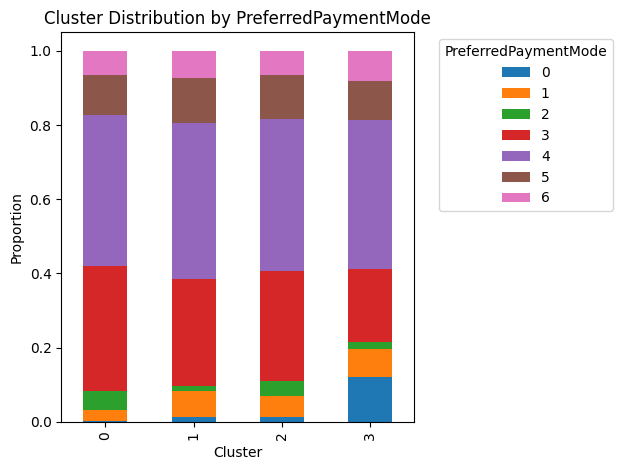


Cluster Distribution - Gender:
Gender          0         1
Cluster                    
0        0.441406  0.558594
1        0.397304  0.602696
2        0.433993  0.566007
3        0.379771  0.620229


<Figure size 1200x600 with 0 Axes>

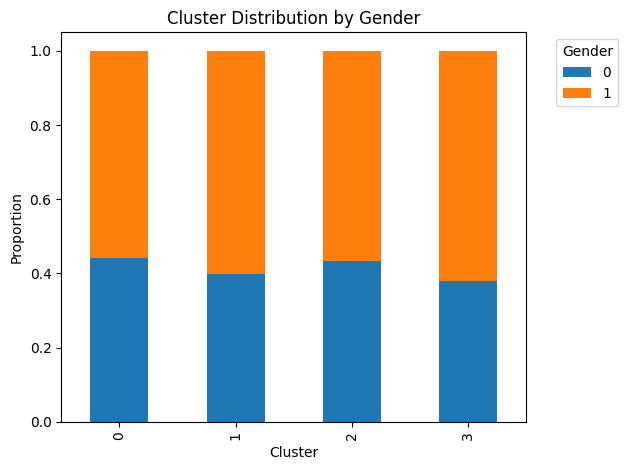


Cluster Distribution - MaritalStatus:
MaritalStatus         0         1         2
Cluster                                    
0              0.180990  0.582031  0.236979
1              0.137997  0.510270  0.351733
2              0.156766  0.580858  0.262376
3              0.138041  0.519720  0.342239


<Figure size 1200x600 with 0 Axes>

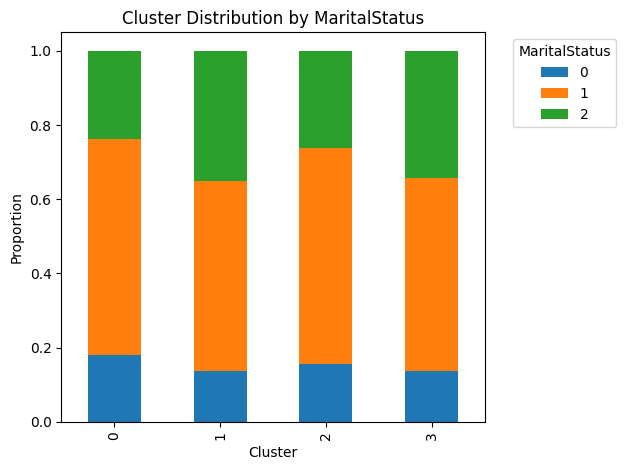

In [ ]:
# 11. Analyze distribution of categorical features across clusters
categorical_features = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'MaritalStatus']

for feature in categorical_features:
    if feature in X_train.columns:
        # Create crosstab with cluster distribution
        cluster_distribution = pd.crosstab(X_train['Cluster'], X_train[feature], normalize='index')
        print(f"\nCluster Distribution - {feature}:")
        print(cluster_distribution)

        # Visualize the distribution
        plt.figure(figsize=(12, 6))
        cluster_distribution.plot(kind='bar', stacked=True)
        plt.title(f'Cluster Distribution by {feature}')
        plt.xlabel('Cluster')
        plt.ylabel('Proportion')
        plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

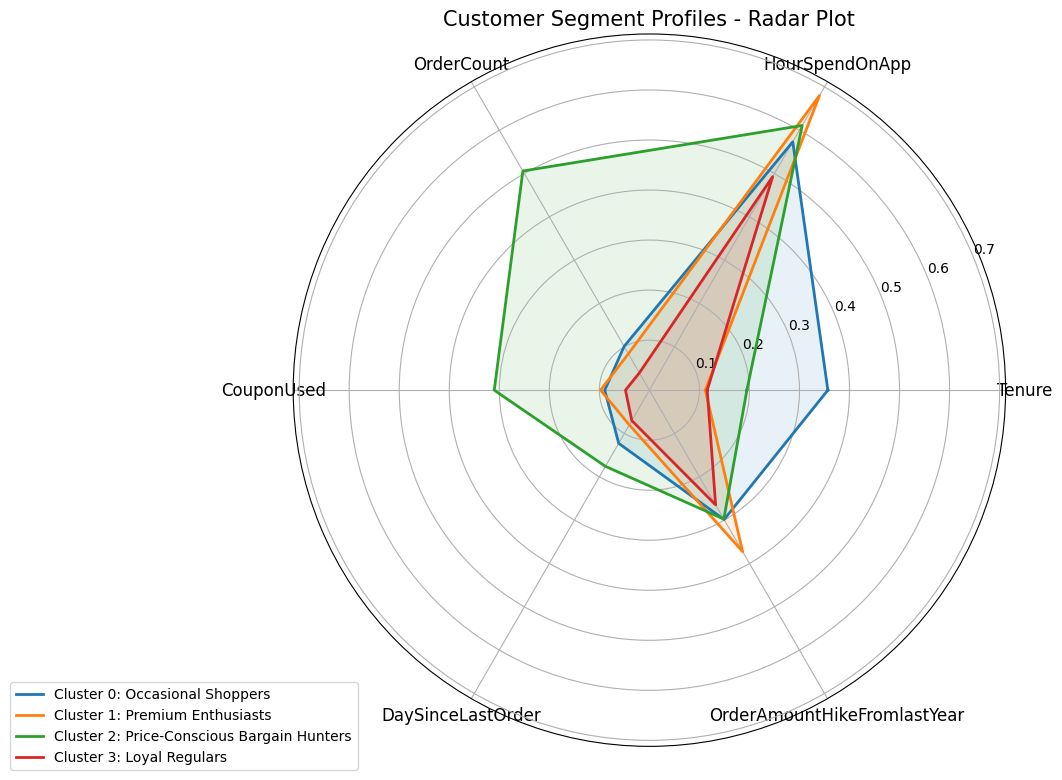

In [ ]:
def radar_plot(df, features, cluster_col='Cluster'):
    # Normalize the data for radar plot
    df_radar = df[features].copy()
    for feature in features:
        df_radar[feature] = (df_radar[feature] - df_radar[feature].min()) / (df_radar[feature].max() - df_radar[feature].min())

    # Get cluster means
    cluster_means = df.groupby(cluster_col)[features].mean()
    normalized_means = cluster_means.copy()
    for feature in features:
        normalized_means[feature] = (normalized_means[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())

    # Number of variables
    N = len(features)

    # Create angle for each feature
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Define cluster names and colors
    cluster_names = {
        0: "Occasional Shoppers",
        1: "Premium Enthusiasts",
        2: "Price-Conscious Bargain Hunters",
        3: "Loyal Regulars"
    }

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))

    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], features, size=12)

    # Draw the cluster lines
    for cluster in sorted(df[cluster_col].unique()):
        values = normalized_means.loc[cluster].values.flatten().tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid',
                label=f'Cluster {cluster}: {cluster_names[cluster]}')
        ax.fill(angles, values, alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Customer Segment Profiles - Radar Plot', size=15)

    return fig

# Create radar plot for clusters
radar_features = selected_features[:6]  # Use a subset of features for clarity
radar_fig = radar_plot(X_train, radar_features)
plt.tight_layout()
plt.show()

### Gaussian Mixture Model (GMM)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [ ]:
# Read the Excel file
df = pd.read_excel('E Commerce Dataset.xlsx', sheet_name='E Comm')
df.head()

CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0  Laptop & Accessory                  2        Single                9   
1              Mobile                  3        Single                7   
2              Mobile                  3        Single                6   
3  Laptop & Accessory                  5        Single                8   
4              Mobile                  5        Single                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                         11.0         1.0         1.0   
1         1                         15.0         0.0         1.0   
2         1                         14.0         0.0         1.0   
3         0                         23.0         0.0         1.0   
4         0                         11.0         1.0         1.0   

   DaySinceLastOrder  CashbackAmount  
0                5.0          159.93  
1                0.0          120.90  
2                3.0          120.28  
3                3.0          134.07  
4                3.0          129.60

In [ ]:
### Check the missing value
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64


In [ ]:
### Replace the missing value with median
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df['WarehouseToHome'] = df['WarehouseToHome'].fillna(df['WarehouseToHome'].median())
df['HourSpendOnApp'] = df['HourSpendOnApp'].fillna(df['HourSpendOnApp'].median())
df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(df['OrderAmountHikeFromlastYear'].median())
df['CouponUsed'] = df['CouponUsed'].fillna(df['CouponUsed'].median())
df['OrderCount'] = df['OrderCount'].fillna(df['OrderCount'].median())
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].median())

In [ ]:
### Label Encoding for Object Datatype
# Identify the object datatype
df.select_dtypes(include='object').nunique()

PreferredLoginDevice    3
PreferredPaymentMode    7
Gender                  2
PreferedOrderCat        6
MaritalStatus           3
dtype: int64

In [ ]:
# Identify the category column
category_col = df.select_dtypes(include=['object']).columns

# Initialize a LabelEncoder object
label_encoder = LabelEncoder()

# Loop over each column to encoder to the unique value
for col in category_col:

    # Fit the encoder to the unique values in the column
    label_encoder.fit(df[col].unique())

    # Transform the column using the encoder
    df[col] = label_encoder.transform(df[col])

    # Print the column name and the unique encoded values
    print(f"{col}: {df[col].unique()}")

# Display the result
df.head()

PreferredLoginDevice: [1 2 0]
PreferredPaymentMode: [4 6 0 2 5 1 3]
Gender: [0 1]
PreferedOrderCat: [2 3 4 5 0 1]
MaritalStatus: [2 0 1]


CustomerID  Churn  Tenure  PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0                     1         3              6.0   
1       50002      1     9.0                     2         1              8.0   
2       50003      1     9.0                     2         1             30.0   
3       50004      1     0.0                     2         3             15.0   
4       50005      1     0.0                     2         1             12.0   

   PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0                     4       0             3.0                         3   
1                     6       1             3.0                         4   
2                     4       1             2.0                         4   
3                     4       1             2.0                         4   
4                     0       1             3.0                         3   

   PreferedOrderCat  SatisfactionScore  MaritalStatus  NumberOfAddress  \
0                 2                  2              2                9   
1                 3                  3              2                7   
2                 3                  3              2                6   
3                 2                  5              2                8   
4                 3                  5              2                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                         11.0         1.0         1.0   
1         1                         15.0         0.0         1.0   
2         1                         14.0         0.0         1.0   
3         0                         23.0         0.0         1.0   
4         0                         11.0         1.0         1.0   

   DaySinceLastOrder  CashbackAmount  
0                5.0          159.93  
1                0.0          120.90  
2                3.0          120.28  
3                3.0          134.07  
4                3.0          129.60

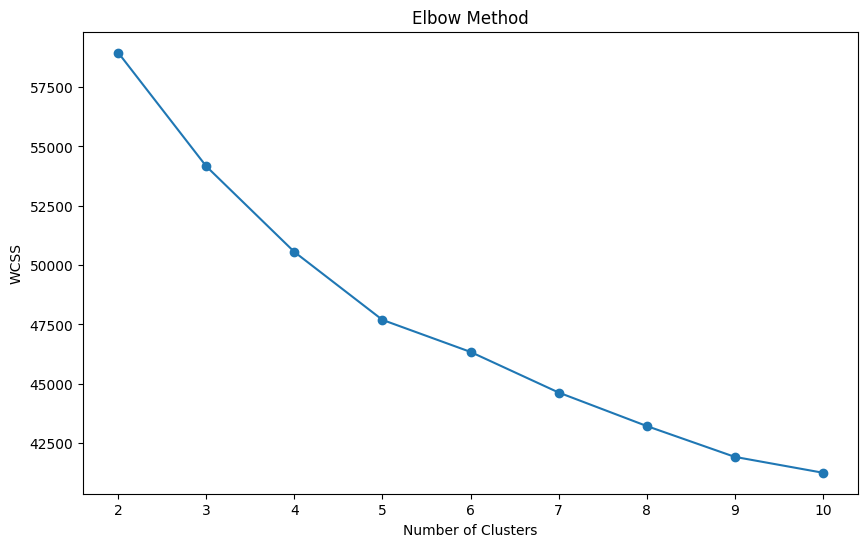

K-Means Silhouette Score: 0.09587880244612434
GMM Silhouette Score: 0.005530816935502573


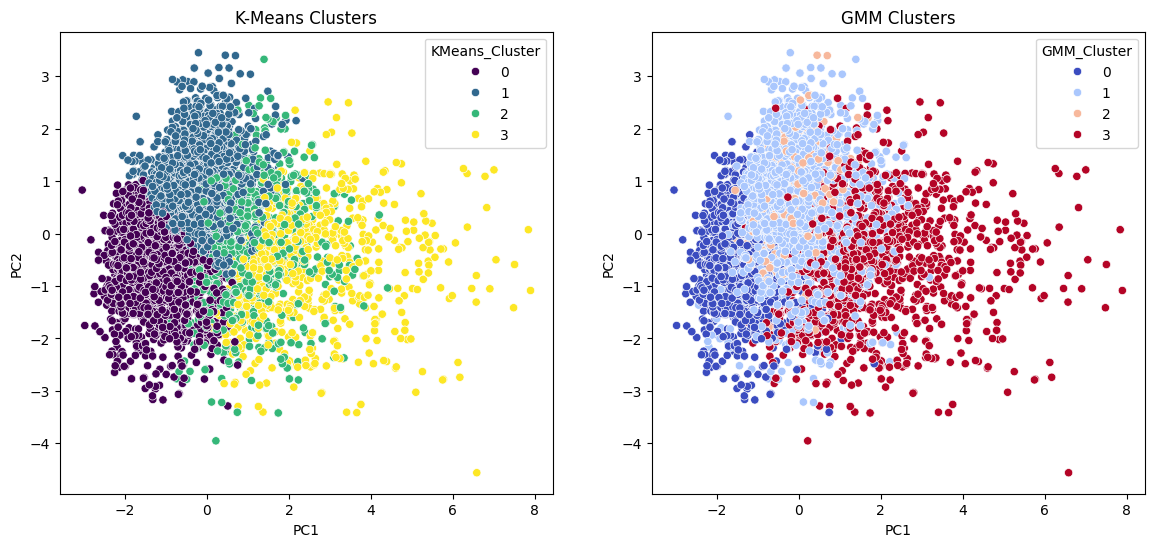

In [ ]:
# Selected Features
selected_features = ['Tenure', 'HourSpendOnApp', 'OrderCount', 'CouponUsed',
                     'DaySinceLastOrder', 'OrderAmountHikeFromlastYear',
                     'SatisfactionScore', 'Complain', 'CityTier',
                     'NumberOfDeviceRegistered', 'NumberOfAddress', 'CashbackAmount']

# Feature Scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[selected_features])

# Elbow Method for Optimal K
wcss = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(df_scaled)

# GMM Clustering
gmm = GaussianMixture(n_components=4, random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(df_scaled)

# Silhouette Score Comparison
print("K-Means Silhouette Score:", silhouette_score(df_scaled, df['KMeans_Cluster']))
print("GMM Silhouette Score:", silhouette_score(df_scaled, df['GMM_Cluster']))

# Visualize Clusters using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df['PC1'] = df_pca[:, 0]
df['PC2'] = df_pca[:, 1]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='PC1', y='PC2', hue='KMeans_Cluster', palette='viridis')
plt.title('K-Means Clusters')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='PC1', y='PC2', hue='GMM_Cluster', palette='coolwarm')
plt.title('GMM Clusters')
plt.show()

###  Generalized Linear Model (GLM)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [ ]:
# GLM-Based Segmentation
X = df[selected_features]
X = sm.add_constant(X)
y = df['Churn']
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 5630
Model:                            GLM   Df Residuals:                     5617
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1764.5
Date:                Fri, 07 Mar 2025   Deviance:                       3528.9
Time:                        23:53:00   Pearson chi2:                 9.00e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2441
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [ ]:
# Features & Target
X = df[selected_features]
y = df['Churn']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Fit GLM Model
glm = LogisticRegression()
glm.fit(X_train, y_train)

# Predict Churn Probability (Propensity Score)
glm_pred = glm.predict_proba(X_test)[:, 1]

# ROC-AUC to evaluate model
auc = roc_auc_score(y_test, glm_pred)
print(f"AUC Score: {auc:.2f}")

# Create Propensity Score (0-100 Scale)
glm_score = (glm_pred * 100).round(2)

# Create Risk Segments
glm_df = pd.DataFrame({
    'CustomerID': df['CustomerID'].iloc[y_test.index],
    'ChurnProbability': glm_pred,
    'PropensityScore': glm_score
})
risk_labels = ['Low', 'Medium', 'High']
glm_df['RiskSegment'] = pd.qcut(glm_df['ChurnProbability'], q=[0, 0.25, 0.75, 1], labels=risk_labels)

glm_df.head(20)

AUC Score: 0.85


CustomerID  ChurnProbability  PropensityScore RiskSegment
4331       54332          0.515779            51.58        High
1988       51989          0.032444             3.24         Low
3443       53444          0.101347            10.13      Medium
4559       54560          0.242782            24.28        High
4898       54899          0.012961             1.30         Low
4641       54642          0.205039            20.50      Medium
2117       52118          0.003281             0.33         Low
3268       53269          0.162225            16.22      Medium
977        50978          0.253278            25.33        High
1115       51116          0.064161             6.42      Medium
3761       53762          0.025387             2.54         Low
2083       52084          0.033909             3.39         Low
577        50578          0.264947            26.49        High
3565       53566          0.004374             0.44         Low
2688       52689          0.120145            12.01      Medium
911        50912          0.524657            52.47        High
80         50081          0.118685            11.87      Medium
425        50426          0.267465            26.75        High
1223       51224          0.015311             1.53         Low
2892       52893          0.304352            30.44        High

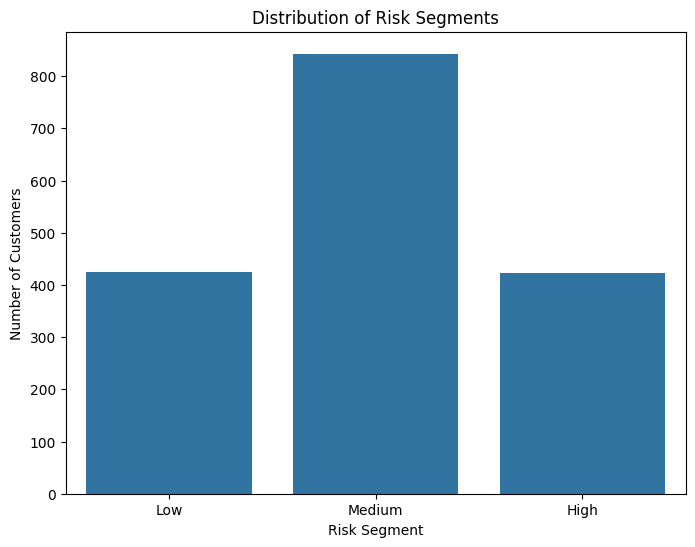

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each RiskSegment
risk_segment_counts = glm_df['RiskSegment'].value_counts()

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=risk_segment_counts.index, y=risk_segment_counts.values)
plt.title('Distribution of Risk Segments')
plt.xlabel('Risk Segment')
plt.ylabel('Number of Customers')
plt.show()

### Recency, Frequency, Monetary (RFM)

- Recency: LastPurchaseDate.
- Frequency: The number of unique transactions per customer.
- Monetary: The total amount for each customer.

In [ ]:
### Replace the missing value with median
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df['WarehouseToHome'] = df['WarehouseToHome'].fillna(df['WarehouseToHome'].median())
df['HourSpendOnApp'] = df['HourSpendOnApp'].fillna(df['HourSpendOnApp'].median())
df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(df['OrderAmountHikeFromlastYear'].median())
df['CouponUsed'] = df['CouponUsed'].fillna(df['CouponUsed'].median())
df['OrderCount'] = df['OrderCount'].fillna(df['OrderCount'].median())
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].median())

### Label Encoding for Object Datatype
# Identify the object datatype
df.select_dtypes(include='object').nunique()

# Identify the category column
category_col = df.select_dtypes(include=['object']).columns

# Initialize a LabelEncoder object
label_encoder = LabelEncoder()

# Loop over each column to encoder to the unique value
for col in category_col:

    # Fit the encoder to the unique values in the column
    label_encoder.fit(df[col].unique())

    # Transform the column using the encoder
    df[col] = label_encoder.transform(df[col])

    # Print the column name and the unique encoded values
    print(f"{col}: {df[col].unique()}")

# Display the result
df.head()

PreferredLoginDevice: [1 2 0]
PreferredPaymentMode: [4 6 0 2 5 1 3]
Gender: [0 1]
PreferedOrderCat: [2 3 4 5 0 1]
MaritalStatus: [2 0 1]


CustomerID  Churn  Tenure  PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0                     1         3              6.0   
1       50002      1     9.0                     2         1              8.0   
2       50003      1     9.0                     2         1             30.0   
3       50004      1     0.0                     2         3             15.0   
4       50005      1     0.0                     2         1             12.0   

   PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0                     4       0             3.0                         3   
1                     6       1             3.0                         4   
2                     4       1             2.0                         4   
3                     4       1             2.0                         4   
4                     0       1             3.0                         3   

   PreferedOrderCat  SatisfactionScore  MaritalStatus  NumberOfAddress  \
0                 2                  2              2                9   
1                 3                  3              2                7   
2                 3                  3              2                6   
3                 2                  5              2                8   
4                 3                  5              2                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                         11.0         1.0         1.0   
1         1                         15.0         0.0         1.0   
2         1                         14.0         0.0         1.0   
3         0                         23.0         0.0         1.0   
4         0                         11.0         1.0         1.0   

   DaySinceLastOrder  CashbackAmount  
0                5.0          159.93  
1                0.0          120.90  
2                3.0          120.28  
3                3.0          134.07  
4                3.0          129.60

In [ ]:
# RFM Analysis Implementation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def perform_rfm_analysis(df):
    # Set a snapshot date (we'll use the most recent day in the dataset as our reference)
    snapshot_date = df['DaySinceLastOrder'].min()

    # Recency: Use DaySinceLastOrder (lower is more recent)
    recency_df = df.groupby('CustomerID')['DaySinceLastOrder'].min().reset_index()
    recency_df.columns = ['CustomerID', 'Recency']

    # Frequency: Use OrderCount
    frequency_df = df.groupby('CustomerID')['OrderCount'].sum().reset_index()
    frequency_df.columns = ['CustomerID', 'Frequency']

    # Monetary: Use CashbackAmount as a proxy for monetary value
    monetary_df = df.groupby('CustomerID')['CashbackAmount'].sum().reset_index()
    monetary_df.columns = ['CustomerID', 'Monetary']

    # Merge RFM metrics
    rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')

    return rfm_df

# Perform RFM Analysis
rfm_df = perform_rfm_analysis(df)

# Normalize RFM metrics for scoring
def normalize_rfm_metrics(rfm_df):
    rfm_normalized = rfm_df.copy()

    # Recency: Invert so that lower days since last order get higher scores
    rfm_normalized['R_score'] = pd.qcut(rfm_normalized['Recency'], q=5, labels=False, duplicates='drop')
    rfm_normalized['R_score'] = 4 - rfm_normalized['R_score']  # Invert to make lower recency better

    # Frequency
    rfm_normalized['F_score'] = pd.qcut(rfm_normalized['Frequency'], q=5, labels=False, duplicates='drop')

    # Monetary
    rfm_normalized['M_score'] = pd.qcut(rfm_normalized['Monetary'], q=5, labels=False, duplicates='drop')

    # Calculate RFM Score (simple average)
    rfm_normalized['RFM_Score'] = (rfm_normalized['R_score'] +
                                    rfm_normalized['F_score'] +
                                    rfm_normalized['M_score']) / 3

    # Segment customers
    rfm_normalized['RFM_Segment'] = pd.cut(
        rfm_normalized['RFM_Score'],
        bins=[-1, 0.2, 0.5, 0.8, 1.1],
        labels=['Very Low', 'Low', 'Medium', 'High']
    )

    return rfm_normalized

# Normalize and segment customers
rfm_segmented = normalize_rfm_metrics(rfm_df)

# Detailed RFM Segment Characteristics
segment_summary = rfm_segmented.groupby('RFM_Segment')[['Recency', 'Frequency', 'Monetary', 'RFM_Score']].mean()
print("\nRFM Segment Characteristics:")
print(segment_summary)


RFM Segment Characteristics:
               Recency  Frequency    Monetary  RFM_Score
RFM_Segment                                             
Very Low     15.833333   1.500000  124.281667   0.000000
Low           7.930769   1.307692  133.777846   0.333333
Medium        7.013333   2.056667  142.993733   0.666667
High          6.698083   2.634185  154.042764   1.000000


<ipython-input-107-bb870b71ded3>:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_summary = rfm_segmented.groupby('RFM_Segment')[['Recency', 'Frequency', 'Monetary', 'RFM_Score']].mean()


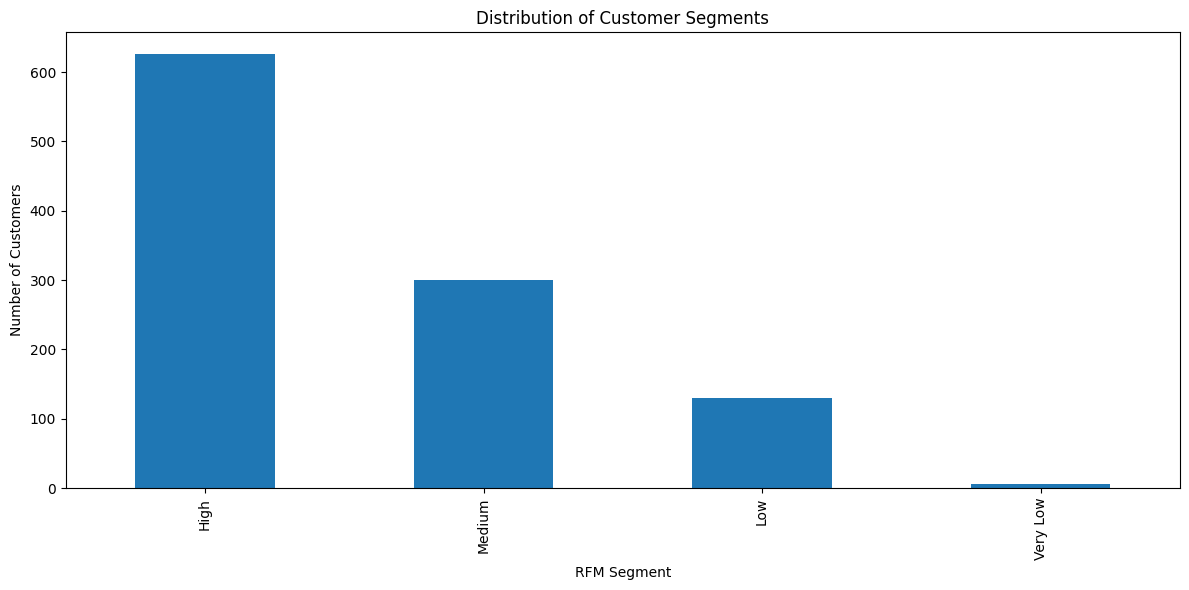

<Figure size 1200x800 with 0 Axes>

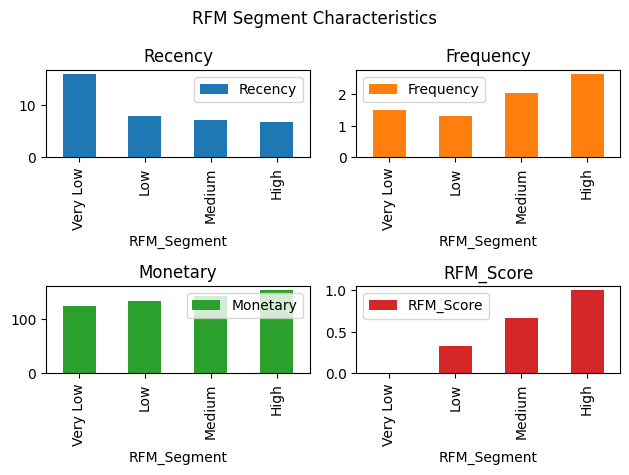

In [ ]:
# Visualization of RFM Segments
plt.figure(figsize=(12, 6))
rfm_segment_counts = rfm_segmented['RFM_Segment'].value_counts()
rfm_segment_counts.plot(kind='bar')
plt.title('Distribution of Customer Segments')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

# Visualization of Segment Characteristics
plt.figure(figsize=(12, 8))
segment_summary.plot(kind='bar', subplots=True, layout=(2,2), sharex=False)
plt.suptitle('RFM Segment Characteristics')
plt.tight_layout()
plt.show()